In [ ]:
!pip install packaging
!pip install ninja
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install zeus-ml
!pip install -U flash-attn --no-build-isolation
!pip install torchao

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.7 MB/s eta 0:00:00
 

Setting Up Energy Tracker (ZeusML)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from functools import partial
from zeus.monitor import ZeusMonitor
import numpy as np

class EnergyTracker:
    def __init__(self, model, precision_modes=None):
        """
        Initialize the EnergyTracker.

        Args:
            model (torch.nn.Module): The model to be tracked.
            precision_modes (str, optional): Precision mode, one of ['float32', 'float16', 'bfloat16']. Defaults to None (float32).
        """
        self.model = model.to('cuda')  # Ensure model is on CUDA
        self.precision_modes = precision_modes
        self.zeus_monitor = ZeusMonitor(
            approx_instant_energy=True,
            gpu_indices=[torch.cuda.current_device()]
        )

        self.component_energy = {
            'attention': [],
            'ffn': [],
            'embeddings': []
        }

        distilbert_model = self.model.distilbert

        # -- Register hooks for embeddings
        distilbert_model.embeddings.register_forward_pre_hook(
            partial(self._energy_hook_begin, 'embeddings')
        )
        distilbert_model.embeddings.register_forward_hook(
            partial(self._energy_hook_end, 'embeddings')
        )

        # -- Register hooks for attention & FFN in each layer
        for layer in distilbert_model.transformer.layer:
            # attention
            layer.attention.register_forward_pre_hook(
                partial(self._energy_hook_begin, 'attention')
            )
            layer.attention.register_forward_hook(
                partial(self._energy_hook_end, 'attention')
            )
            # ffn
            layer.ffn.register_forward_pre_hook(
                partial(self._energy_hook_begin, 'ffn')
            )
            layer.ffn.register_forward_hook(
                partial(self._energy_hook_end, 'ffn')
            )

    def _energy_hook_begin(self, component_name, module, input):
        """
        Pre-forward hook: Start the measurement window.

        Signature: forward_pre_hook(module, inputs) -> None
        """
        torch.cuda.synchronize()  # Ensure any pending CUDA ops finish
        self.zeus_monitor.begin_window(component_name)

    def _energy_hook_end(self, component_name, module, input, output):
        """
        Post-forward hook: End the measurement window, record the energy.

        Signature: forward_hook(module, inputs, outputs) -> None
        """
        torch.cuda.synchronize()  # Ensure forward pass is fully completed
        energy = self.zeus_monitor.end_window(component_name).total_energy
        self.component_energy[component_name].append(energy)
    def measure(self, input_ids, attention_mask=None):
        """
        Measure the energy consumption of the forward pass.

        Args:
            input_ids (torch.Tensor): The input IDs for the model.
            attention_mask (torch.Tensor, optional): The attention mask for the model.

        Returns:
            tuple: (logits, energy metrics)
        """
        # Clear old energy measurements
        for component in self.component_energy:
            self.component_energy[component].clear()

        # Run the forward pass with precision control if precision mode is set
        window = None
        if self.precision_modes == "mixed":
            self.zeus_monitor.begin_window('inference')
            with torch.no_grad(), torch.cuda.amp.autocast():
                outputs = self.model(input_ids, attention_mask=attention_mask)
            window = self.zeus_monitor.end_window('inference')
        elif self.precision_modes == 'bfloat16':
            self.zeus_monitor.begin_window('inference')
            with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
                outputs = self.model(input_ids, attention_mask=attention_mask)
            window = self.zeus_monitor.end_window('inference')
        elif self.precision_modes == 'float16':
            self.zeus_monitor.begin_window('inference')
            with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
                outputs = self.model(input_ids, attention_mask=attention_mask)
            window = self.zeus_monitor.end_window('inference')
        else:
            self.zeus_monitor.begin_window('inference')
            with torch.no_grad():
                outputs = self.model(input_ids, attention_mask=attention_mask)
            window = self.zeus_monitor.end_window('inference')

        total_energy = window.total_energy
        time = window.time

        num_tokens = attention_mask.sum().item()
        results = {
            'total_energy': total_energy,
            'energy_per_token': total_energy / num_tokens,
            'num_tokens' : num_tokens,
            'time' : time,
            'energy_per_inference': total_energy,
            'components': {
                'attention': {
                    'energy': np.sum(self.component_energy['attention'])
                },
                'ffn': {
                    'energy': np.sum(self.component_energy['ffn'])
                },
                'embeddings': {
                    'energy': np.sum(self.component_energy['embeddings'])
                }
            }
        }

        return outputs.logits, results


Setting up Monitoring Functions

In [ ]:
import torch
from transformers import DataCollatorWithPadding
from datasets import load_dataset, concatenate_datasets
from torch.utils.data import DataLoader
from evaluate import load
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import json
import numpy as np


def convert_numpy(obj):
    """Recursively convert NumPy types to Python native types."""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()  # Convert NumPy array to list
    elif isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}  # Recursively convert dict
    elif isinstance(obj, list):
        return [convert_numpy(i) for i in obj]  # Recursively convert list
    else:
        return obj


def run_glue_energy_monitoring(model, tokenizer, dataset_name="sst2", batch_size=16, precision_modes=None):
    # Load the GLUE dataset
    dataset = load_dataset("glue", dataset_name)

    # Preprocess function for each dataset
    def preprocess_function(examples):
        if dataset_name == 'mrpc':
            return tokenizer(examples['sentence1'], examples['sentence2'], padding="max_length", truncation=True, max_length=128)
        elif dataset_name == 'mnli':
            return tokenizer(examples['premise'], examples['hypothesis'], padding="max_length", truncation=True, max_length=128)
        elif dataset_name in ['sst2', 'cola']:
            return tokenizer(examples['sentence'], padding="max_length", truncation=True, max_length=128)

    # Apply tokenization to all splits
    encoded_dataset = dataset.map(preprocess_function, batched=True)

    # Set format for train, validation, and test sets
    encoded_dataset['train'].set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    if dataset_name == 'mnli':
        # Concatenate validation matched and mismatched for MNLI
        validation_dataset = concatenate_datasets([encoded_dataset['validation_matched'], encoded_dataset['validation_mismatched']])
    else:
        validation_dataset = encoded_dataset['validation']

    validation_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    # Create DataLoader for batch processing
    data_collator = DataCollatorWithPadding(tokenizer)
    dataloader = DataLoader(validation_dataset, batch_size=batch_size, collate_fn=data_collator)

    tracker = EnergyTracker(model, precision_modes=precision_modes)  # Pass precision_modes to EnergyTracker
    key_metrics = []
    all_predictions = []
    all_true_labels = []

    for batch_index, batch in enumerate(dataloader):
        input_ids = batch['input_ids'].to('cuda')  # Ensure input_ids are on CUDA
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        # --- Get logits and energy metrics ---
        logits, energy_metrics = tracker.measure(input_ids, attention_mask=attention_mask)

        # --- Calculate predictions and store them for overall evaluation ---
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()  # Get predictions from logits
        true_labels = labels.cpu().numpy()  # Move labels to CPU for metrics

        all_predictions.extend(predictions)
        all_true_labels.extend(true_labels)

        # Store the key metrics for this batch
        batch_metrics = {
            'batch_index': batch_index,
            'batch_size': batch['input_ids'].size(0),
            'total_energy': energy_metrics['total_energy'],
            'energy_per_token': energy_metrics['energy_per_token'],
            'energy_per_inference': energy_metrics['energy_per_inference'],
            'component_breakdown': energy_metrics['components'],
            'batch_time': energy_metrics['time'],
            'batch_tokens': energy_metrics['num_tokens']
        }

        key_metrics.append(batch_metrics)

    # --- Calculate overall GLUE score for the entire dataset ---
    if dataset_name == 'sst2' or dataset_name == 'mnli':
        final_score = accuracy_score(all_true_labels, all_predictions)
    elif dataset_name == 'cola':
        final_score = matthews_corrcoef(all_true_labels, all_predictions)
    elif dataset_name == 'mrpc':
        f1 = f1_score(all_true_labels, all_predictions)
        acc = accuracy_score(all_true_labels, all_predictions)
        final_score = (f1 + acc) / 2  # Average of F1 and accuracy, as done in GLUE
    else:
        final_score = 0  # Default if task not found

    # --- Calculate average metrics for all batches ---
    avg_metrics = {
        'total_energy': np.sum([bm['total_energy'] for bm in key_metrics]),
        'final_glue_score': final_score,
        'avg_energy_per_token': np.sum([bm['total_energy'] for bm in key_metrics])/np.sum([bm['batch_tokens'] for bm in key_metrics]),
        'avg_throughput': np.sum([bm['batch_tokens'] for bm in key_metrics])/np.sum([bm['batch_time'] for bm in key_metrics]),
        'total_component_energy': {
            'attention': np.sum([bm['component_breakdown']['attention']['energy'] for bm in key_metrics]),
            'ffn': np.sum([bm['component_breakdown']['ffn']['energy'] for bm in key_metrics]),
            'embeddings': np.sum([bm['component_breakdown']['embeddings']['energy'] for bm in key_metrics])
        }
    }

    # --- Convert NumPy types in avg_metrics before serialization ---
    clean_avg_metrics = convert_numpy(avg_metrics)

    return key_metrics, clean_avg_metrics

Setting Up Carbon Emission Utilies

In [ ]:
import geocoder
import requests

def get_carbon_intensity():
    g = geocoder.ip('me')
    latitude = g.latlng[0]
    longitude = g.latlng[1]
    # Replace with your Electricity Maps API key
    API_KEY = "gGpKkf1FBhsZb"

    # API URL
    url = "https://api.electricitymap.org/v3/carbon-intensity/latest"

    # Headers for authentication
    headers = {
        "auth-token": API_KEY
    }

    # Query parameters
    params = {
        "lat": latitude,
        "lon": longitude
    }

    # Make the request
    response = requests.get(url, headers=headers, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()
        carbonIntensity = data.get("carbonIntensity")
        #gCO2eq/kWh
        return carbonIntensity
    else:
        print("Error:", response.status_code, response.text)
        raise Exception(response.text)

# returns mg of Carbon Dioxide
def joules_to_carbon(joules, carbonIntensity):
    # print(f"JOU: {total_energy_j}")
    # print(f"CARBON: {carbonIntensity}")
    ans = (joules*carbonIntensity) / 3600
    # print(f"ANS: {ans}")
    return ans

carbonIntensity = get_carbon_intensity()

In [ ]:
carbonIntensity

467

# Getting FineTuned DistillBERT and Baseline Profiling

In [ ]:
task_to_model = {
    "sst2": "distilbert-base-uncased-finetuned-sst-2-english",
    "cola": "textattack/distilbert-base-uncased-coLA",
    "mrpc": "textattack/distilbert-base-uncased-mrpc",
    "mnli": "textattack/distilbert-base-uncased-MNLI"
}

# Define your tasks
single_sentence_tasks = ["sst2", "cola"]
pairwise_tasks = ["mrpc","mnli"]

all_clean_avg_metrics = {}
print("SINGLE SENTENCE TASKS")
for task in single_sentence_tasks:
    model_name = task_to_model[task]
    # Load the model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # Move model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    key_metrics, clean_avg_metrics = run_glue_energy_monitoring(
                    model, tokenizer, dataset_name=task, batch_size=16,precision_modes=None
                )
    all_clean_avg_metrics[task] = clean_avg_metrics
    carbon_i = joules_to_carbon(all_clean_avg_metrics[task]['total_energy'], carbonIntensity)
    print(f"--- {task} ---")
    print("\n--- Overall Averages ---")
    print(f"Emissions:{carbon_i:.4f} mg CO2eq")
    print(f"Total Energy: {all_clean_avg_metrics[task]['total_energy']:.4f} J")
    print(f"  Final GLUE Score: {all_clean_avg_metrics[task]['final_glue_score']:.4f}")
    print(f"  Average Energy per Token: {all_clean_avg_metrics[task]['avg_energy_per_token']:.4f} J")
    print(f"  Average Throughput: {all_clean_avg_metrics[task]['avg_throughput']:.4f} Tokens/sec")
    print(f"Component Energy: {json.dumps(all_clean_avg_metrics[task]['total_component_energy'], indent=4)}")



SINGLE SENTENCE TASKS
[2024-12-16 07:07:43,607] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:07:43,608] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []
--- sst2 ---

--- Overall Averages ---
Emissions:41.6192 mg CO2eq
Total Energy: 320.8330 J
  Final GLUE Score: 0.9106
  Average Energy per Token: 0.0146 J
  Average Throughput: 4084.6450 Tokens/sec
Component Energy: {
    "attention": 171.77297846336197,
    "ffn": 83.94480660653487,
    "embeddings": 6.752123722791672
}
[2024-12-16 07:07:55,985] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:07:55,986] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []
--- cola ---

--- Overall Averages ---
Emissions:48.5093 mg CO2eq
Total Energy: 373.9478 J
  Final GLUE Score: 0.5686
  Average Energy per Token: 0.0307 J
  Average Throughput: 1915.8277 Tokens/sec
Component Energy: {
    "attention": 113.96091571594773,
    "ffn": 94.84531882667635,
    "embed

In [ ]:
print("PAIRWISE SENTENCE TASKS")
for task in pairwise_tasks:
    model_name = task_to_model[task]
    # Load the model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # Move model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    key_metrics, clean_avg_metrics = run_glue_energy_monitoring(
                    model, tokenizer, dataset_name=task, batch_size=16
                )
    all_clean_avg_metrics[task] = clean_avg_metrics
    carbon_i = joules_to_carbon(all_clean_avg_metrics[task]['total_energy'], carbonIntensity)
    print(f"--- {task} ---")
    print("\n--- Overall Averages ---")
    print(f"Emissions:{carbon_i:.4f} mg CO2eq")
    print(f"Total Energy: {all_clean_avg_metrics[task]['total_energy']:.4f} J")
    print(f"  Final GLUE Score: {all_clean_avg_metrics[task]['final_glue_score']:.4f}")
    print(f"  Average Energy per Token: {all_clean_avg_metrics[task]['avg_energy_per_token']:.4f} J")
    print(f"  Average Throughput: {all_clean_avg_metrics[task]['avg_throughput']:.4f} Tokens/sec")
    print(f"Component Energy: {json.dumps(all_clean_avg_metrics[task]['total_component_energy'], indent=4)}")

PAIRWISE SENTENCE TASKS
[2024-12-16 06:58:34,182] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 06:58:34,183] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []
--- mrpc ---

--- Overall Averages ---
Emissions:19.6924 mg CO2eq
Total Energy: 146.1707 J
  Final GLUE Score: 0.8803
  Average Energy per Token: 0.0067 J
  Average Throughput: 8724.0604 Tokens/sec
Component Energy: {
    "attention": 34.01548307514749,
    "ffn": 21.833095955610275,
    "embeddings": 14.764698335392401
}


Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

[2024-12-16 06:58:44,639] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 06:58:44,639] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []
--- mnli ---

--- Overall Averages ---
Emissions:940.4593 mg CO2eq
Total Energy: 6980.7290 J
  Final GLUE Score: 0.0861
  Average Energy per Token: 0.0089 J
  Average Throughput: 6641.3065 Tokens/sec
Component Energy: {
    "attention": 2606.8340218135204,
    "ffn": 2873.207102688337,
    "embeddings": 314.70811132120525
}


# Trying Mixed Precision
*   Try with fp16, bf16, and then one with truly mixed



In [ ]:
import json

precision_modes = ['float16', 'bfloat16', 'mixed']

print("SINGLE SENTENCE TASKS")
all_clean_avg_metrics = {}
carbonIntensity = 0.233  # Example carbon intensity in gCO2eq/kWh

for task in single_sentence_tasks:
    model_name = task_to_model[task]

    # Load the model and tokenizer once for this task
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Move model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    for precision_mode in precision_modes:
        print(f"--- {model_name} {task} {precision_mode} ---")

        # Run GLUE energy monitoring for each precision mode
        key_metrics, clean_avg_metrics = run_glue_energy_monitoring(
            model,
            tokenizer,
            dataset_name=task,
            batch_size=16,
            precision_modes=precision_mode
        )

        all_clean_avg_metrics[task] = clean_avg_metrics
        total_energy_j = all_clean_avg_metrics[task]['total_energy']
        #print(f"eng: {total_energy_j}")
        carbonIntensity = get_carbon_intensity()
        carbon_i = joules_to_carbon(total_energy_j, carbonIntensity)
        print(f"--- {task} ({precision_mode}) ---")
        print("\n--- Overall Averages ---")
        print(f"Emissions:{carbon_i:.4f} mg CO2eq")
        print(f"Total Energy: {all_clean_avg_metrics[task]['total_energy']:.4f} J")
        print(f"  Final GLUE Score: {all_clean_avg_metrics[task]['final_glue_score']:.4f}")
        print(f"  Average Energy per Token: {all_clean_avg_metrics[task]['avg_energy_per_token']:.4f} J")
        print(f"  Average Throughput: {all_clean_avg_metrics[task]['avg_throughput']:.4f} Tokens/sec")
        print(f"Component Energy: {json.dumps(all_clean_avg_metrics[task]['total_component_energy'], indent=4)}")

SINGLE SENTENCE TASKS
--- distilbert-base-uncased-finetuned-sst-2-english sst2 float16 ---
[2024-12-16 07:20:05,058] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:20:05,059] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []


<ipython-input-44-aae995fc8988>:103: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):


--- sst2 (float16) ---

--- Overall Averages ---
Emissions:39.3066 mg CO2eq
Total Energy: 303.0060 J
  Final GLUE Score: 0.9106
  Average Energy per Token: 0.0138 J
  Average Throughput: 4073.5871 Tokens/sec
Component Energy: {
    "attention": 136.08582297043222,
    "ffn": 137.75661904523523,
    "embeddings": 12.55170819619391
}
--- distilbert-base-uncased-finetuned-sst-2-english sst2 bfloat16 ---
[2024-12-16 07:20:16,198] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:20:16,199] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []


<ipython-input-44-aae995fc8988>:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):


--- sst2 (bfloat16) ---

--- Overall Averages ---
Emissions:71.0568 mg CO2eq
Total Energy: 547.7610 J
  Final GLUE Score: 0.9106
  Average Energy per Token: 0.0250 J
  Average Throughput: 2177.6822 Tokens/sec
Component Energy: {
    "attention": 273.57534786992613,
    "ffn": 256.38958972638756,
    "embeddings": 44.74335557281692
}
--- distilbert-base-uncased-finetuned-sst-2-english sst2 mixed ---
[2024-12-16 07:20:32,188] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:20:32,190] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []


<ipython-input-44-aae995fc8988>:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


--- sst2 (mixed) ---

--- Overall Averages ---
Emissions:100.2419 mg CO2eq
Total Energy: 772.7430 J
  Final GLUE Score: 0.9106
  Average Energy per Token: 0.0352 J
  Average Throughput: 1483.8804 Tokens/sec
Component Energy: {
    "attention": 411.75896759480514,
    "ffn": 400.10553313399566,
    "embeddings": 60.10634662614204
}
--- textattack/distilbert-base-uncased-coLA cola float16 ---
[2024-12-16 07:20:54,674] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:20:54,675] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []


<ipython-input-44-aae995fc8988>:103: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):


--- cola (float16) ---

--- Overall Averages ---
Emissions:47.0069 mg CO2eq
Total Energy: 362.3660 J
  Final GLUE Score: 0.5686
  Average Energy per Token: 0.0298 J
  Average Throughput: 1897.2820 Tokens/sec
Component Energy: {
    "attention": 205.46393181718233,
    "ffn": 135.50054771542645,
    "embeddings": 13.93136486648675
}
--- textattack/distilbert-base-uncased-coLA cola bfloat16 ---
[2024-12-16 07:21:07,362] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:21:07,363] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []


<ipython-input-44-aae995fc8988>:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):


--- cola (bfloat16) ---

--- Overall Averages ---
Emissions:84.1272 mg CO2eq
Total Energy: 648.5180 J
  Final GLUE Score: 0.5686
  Average Energy per Token: 0.0533 J
  Average Throughput: 1008.4878 Tokens/sec
Component Energy: {
    "attention": 318.5000872200355,
    "ffn": 301.2483383222995,
    "embeddings": 63.38601994721498
}
--- textattack/distilbert-base-uncased-coLA cola mixed ---
[2024-12-16 07:21:25,296] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:21:25,297] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []


<ipython-input-44-aae995fc8988>:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


--- cola (mixed) ---

--- Overall Averages ---
Emissions:120.7714 mg CO2eq
Total Energy: 931.0000 J
  Final GLUE Score: 0.5686
  Average Energy per Token: 0.0765 J
  Average Throughput: 687.6260 Tokens/sec
Component Energy: {
    "attention": 454.6701633500997,
    "ffn": 446.6206743446821,
    "embeddings": 80.33969830932095
}


In [ ]:
print("PAIRWISE SENTENCE TASKS")
all_clean_avg_metrics = {}


for task in pairwise_tasks :
    model_name = task_to_model[task]

    # Load the model and tokenizer once for this task
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Move model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    for precision_mode in precision_modes:
        print(f"--- {model_name} {task} {precision_mode} ---")

        # Run GLUE energy monitoring for each precision mode
        key_metrics, clean_avg_metrics = run_glue_energy_monitoring(
            model,
            tokenizer,
            dataset_name=task,
            batch_size=16,
            precision_modes=precision_mode
        )

        all_clean_avg_metrics[task] = clean_avg_metrics
        carbonIntensity = get_carbon_intensity()
        carbon_i = joules_to_carbon(all_clean_avg_metrics[task]['total_energy'], carbonIntensity)
        print(f"--- {task} ({precision_mode}) ---")
        print("\n--- Overall Averages ---")
        print(f"Emissions:{carbon_i:.4f} mg CO2eq")
        print(f"Total Energy: {all_clean_avg_metrics[task]['total_energy']:.4f} J")
        print(f"  Final GLUE Score: {all_clean_avg_metrics[task]['final_glue_score']:.4f}")
        print(f"  Average Energy per Token: {all_clean_avg_metrics[task]['avg_energy_per_token']:.4f} J")
        print(f"  Average Throughput: {all_clean_avg_metrics[task]['avg_throughput']:.4f} Tokens/sec")
        print(f"Component Energy: {json.dumps(all_clean_avg_metrics[task]['total_component_energy'], indent=4)}")

PAIRWISE SENTENCE TASKS
--- textattack/distilbert-base-uncased-mrpc mrpc float16 ---
[2024-12-16 07:22:22,635] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:22:22,636] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []


<ipython-input-44-aae995fc8988>:103: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):


--- mrpc (float16) ---

--- Overall Averages ---
Emissions:18.4323 mg CO2eq
Total Energy: 142.0903 J
  Final GLUE Score: 0.8803
  Average Energy per Token: 0.0065 J
  Average Throughput: 8546.4043 Tokens/sec
Component Energy: {
    "attention": 66.65832333812489,
    "ffn": 53.96795279666968,
    "embeddings": 14.214280652335846
}
--- textattack/distilbert-base-uncased-mrpc mrpc bfloat16 ---


Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

[2024-12-16 07:22:31,545] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:22:31,546] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []


<ipython-input-44-aae995fc8988>:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):


--- mrpc (bfloat16) ---

--- Overall Averages ---
Emissions:33.3784 mg CO2eq
Total Energy: 257.3070 J
  Final GLUE Score: 0.8803
  Average Energy per Token: 0.0118 J
  Average Throughput: 4540.4528 Tokens/sec
Component Energy: {
    "attention": 138.2615320813097,
    "ffn": 137.25174707317817,
    "embeddings": 14.463903595376758
}
--- textattack/distilbert-base-uncased-mrpc mrpc mixed ---
[2024-12-16 07:22:42,674] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:22:42,675] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []


<ipython-input-44-aae995fc8988>:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


--- mrpc (mixed) ---

--- Overall Averages ---
Emissions:47.6235 mg CO2eq
Total Energy: 367.1190 J
  Final GLUE Score: 0.8803
  Average Energy per Token: 0.0169 J
  Average Throughput: 3111.8531 Tokens/sec
Component Energy: {
    "attention": 172.9729921956584,
    "ffn": 176.060744169225,
    "embeddings": 29.111033092263156
}
--- textattack/distilbert-base-uncased-MNLI mnli float16 ---
[2024-12-16 07:22:57,330] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:22:57,331] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []


<ipython-input-44-aae995fc8988>:103: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):


--- mnli (float16) ---

--- Overall Averages ---
Emissions:870.8697 mg CO2eq
Total Energy: 6713.3426 J
  Final GLUE Score: 0.0861
  Average Energy per Token: 0.0086 J
  Average Throughput: 6552.1518 Tokens/sec
Component Energy: {
    "attention": 2880.0709315279464,
    "ffn": 2590.140828017751,
    "embeddings": 421.02158588049934
}
--- textattack/distilbert-base-uncased-MNLI mnli bfloat16 ---


Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

[2024-12-16 07:25:41,884] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:25:41,885] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []


<ipython-input-44-aae995fc8988>:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):


--- mnli (bfloat16) ---

--- Overall Averages ---
Emissions:1549.6653 mg CO2eq
Total Energy: 11946.0280 J
  Final GLUE Score: 0.0861
  Average Energy per Token: 0.0152 J
  Average Throughput: 3489.4689 Tokens/sec
Component Energy: {
    "attention": 6024.692480586128,
    "ffn": 5873.675665218769,
    "embeddings": 1013.0208477373999
}
--- textattack/distilbert-base-uncased-MNLI mnli mixed ---
[2024-12-16 07:29:39,930] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:29:39,931] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []


<ipython-input-44-aae995fc8988>:93: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


--- mnli (mixed) ---

--- Overall Averages ---
Emissions:2260.1709 mg CO2eq
Total Energy: 17423.1590 J
  Final GLUE Score: 0.0861
  Average Energy per Token: 0.0222 J
  Average Throughput: 2383.8842 Tokens/sec
Component Energy: {
    "attention": 9107.92302121641,
    "ffn": 9040.487503655255,
    "embeddings": 1485.216422858312
}


# Trying Flash Attention - 2

In [ ]:
all_clean_avg_metrics = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("SINGLE SENTENCE TASKS")
for task in single_sentence_tasks:
    model_name = task_to_model[task]
    # Load the model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_name,torch_dtype=torch.bfloat16,  # or torch.float16
    attn_implementation="flash_attention_2").to('cuda')
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model.eval()
    key_metrics, clean_avg_metrics = run_glue_energy_monitoring(
                    model, tokenizer, dataset_name=task, batch_size=16,precision_modes=None
                )
    all_clean_avg_metrics[task] = clean_avg_metrics
    carbonIntensity = get_carbon_intensity()
    carbon_i = joules_to_carbon(all_clean_avg_metrics[task]['total_energy'], carbonIntensity)
    print(f"--- {task} ---")
    print("\n--- Overall Averages ---")
    print(f"Emissions:{carbon_i:.4f} mg CO2eq")
    print(f"Total Energy: {all_clean_avg_metrics[task]['total_energy']:.4f} J")
    print(f"  Final GLUE Score: {all_clean_avg_metrics[task]['final_glue_score']:.4f}")
    print(f"  Average Energy per Token: {all_clean_avg_metrics[task]['avg_energy_per_token']:.4f} J")
    print(f"  Average Throughput: {all_clean_avg_metrics[task]['avg_throughput']:.4f} Tokens/sec")
    print(f"Component Energy: {json.dumps(all_clean_avg_metrics[task]['total_component_energy'], indent=4)}")
    del model
    del tokenizer

SINGLE SENTENCE TASKS
[2024-12-16 07:38:23,401] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:38:23,402] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []
--- sst2 ---

--- Overall Averages ---
Emissions:39.9221 mg CO2eq
Total Energy: 307.7510 J
  Final GLUE Score: 0.9083
  Average Energy per Token: 0.0140 J
  Average Throughput: 3927.9292 Tokens/sec
Component Energy: {
    "attention": 170.17276718401163,
    "ffn": 143.8158975356333,
    "embeddings": 22.980687871317382
}
[2024-12-16 07:38:36,484] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:38:36,485] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []
--- cola ---

--- Overall Averages ---
Emissions:46.8735 mg CO2eq
Total Energy: 361.3374 J
  Final GLUE Score: 0.5689
  Average Energy per Token: 0.0297 J
  Average Throughput: 1824.6967 Tokens/sec
Component Energy: {
    "attention": 156.60857428638545,
    "ffn": 152.7765700141406,
    "embe

In [ ]:
all_clean_avg_metrics = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PAIRWAISE SENTENCE TASKS")
for task in pairwise_tasks:
    model_name = task_to_model[task]
    # Load the model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_name,torch_dtype=torch.bfloat16,  # or torch.bfloat16
    attn_implementation="flash_attention_2").to('cuda')
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model.eval()
    key_metrics, clean_avg_metrics = run_glue_energy_monitoring(
                    model, tokenizer, dataset_name=task, batch_size=16,precision_modes=None
                )
    all_clean_avg_metrics[task] = clean_avg_metrics
    carbonIntensity = get_carbon_intensity()
    carbon_i = joules_to_carbon(all_clean_avg_metrics[task]['total_energy'], carbonIntensity)
    print(f"--- {task} ---")
    print("\n--- Overall Averages ---")
    print(f"Emissions:{carbon_i:.4f} mg CO2eq")
    print(f"Total Energy: {all_clean_avg_metrics[task]['total_energy']:.4f} J")
    print(f"  Final GLUE Score: {all_clean_avg_metrics[task]['final_glue_score']:.4f}")
    print(f"  Average Energy per Token: {all_clean_avg_metrics[task]['avg_energy_per_token']:.4f} J")
    print(f"  Average Throughput: {all_clean_avg_metrics[task]['avg_throughput']:.4f} Tokens/sec")
    print(f"Component Energy: {json.dumps(all_clean_avg_metrics[task]['total_component_energy'], indent=4)}")
    del model
    del tokenizer

PAIRWAISE SENTENCE TASKS
[2024-12-16 07:39:32,142] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:39:32,143] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []
--- mrpc ---

--- Overall Averages ---
Emissions:18.2232 mg CO2eq
Total Energy: 140.4787 J
  Final GLUE Score: 0.8781
  Average Energy per Token: 0.0065 J
  Average Throughput: 8302.0584 Tokens/sec
Component Energy: {
    "attention": 80.60524851087575,
    "ffn": 57.121510837071575,
    "embeddings": 14.081143541815692
}
[2024-12-16 07:39:42,513] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:39:42,514] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []
--- mnli ---

--- Overall Averages ---
Emissions:868.0897 mg CO2eq
Total Energy: 6691.9123 J
  Final GLUE Score: 0.0859
  Average Energy per Token: 0.0085 J
  Average Throughput: 6333.8994 Tokens/sec
Component Energy: {
    "attention": 3345.157030786271,
    "ffn": 2737.098883803421,
    "

# Trying Flash + Mixed

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import json
from torch.cuda.amp import autocast, GradScaler  # For mixed precision

all_clean_avg_metrics = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("SINGLE SENTENCE TASKS")
for task in single_sentence_tasks:
    model_name = task_to_model[task]

    # Step 1: Set model weights to bfloat16
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        torch_dtype=torch.float16,  # Weights in bfloat16 for better stability
        attn_implementation="flash_attention_2"
    ).to(device)  # Move to CUDA device

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model.eval()
    # Step 2: Use autocast with FP16 for computation
    key_metrics, clean_avg_metrics = run_glue_energy_monitoring(
            model, tokenizer, dataset_name=task, batch_size=16, precision_modes='float16'
        )

    all_clean_avg_metrics[task] = clean_avg_metrics

    carbonIntensity = get_carbon_intensity()
    carbon_i = joules_to_carbon(all_clean_avg_metrics[task]['total_energy'], carbonIntensity)
    print(f"--- {task} ---")
    print("\n--- Overall Averages ---")
    print(f"Emissions: {carbon_i:.4f} mg CO2eq")
    print(f"Total Energy: {all_clean_avg_metrics[task]['total_energy']:.4f} J")
    print(f"Final GLUE Score: {all_clean_avg_metrics[task]['final_glue_score']:.4f}")
    print(f"Average Energy per Token: {all_clean_avg_metrics[task]['avg_energy_per_token']:.4f} J")
    print(f"Average Throughput: {all_clean_avg_metrics[task]['avg_throughput']:.4f} Tokens/sec")
    print(f"Component Energy: {json.dumps(all_clean_avg_metrics[task]['total_component_energy'], indent=4)}")

    # Free memory to avoid OOM issues
    del model
    del tokenizer
    torch.cuda.empty_cache()


SINGLE SENTENCE TASKS
[2024-12-16 08:00:28,351] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 08:00:28,352] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []


<ipython-input-44-aae995fc8988>:103: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):


--- sst2 ---

--- Overall Averages ---
Emissions: 40.9903 mg CO2eq
Total Energy: 299.9290 J
Final GLUE Score: 0.9106
Average Energy per Token: 0.0137 J
Average Throughput: 3912.1049 Tokens/sec
Component Energy: {
    "attention": 145.8728818293549,
    "ffn": 104.27338178142531,
    "embeddings": 23.397206175505186
}
[2024-12-16 08:00:41,122] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 08:00:41,123] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []


<ipython-input-44-aae995fc8988>:103: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):


--- cola ---

--- Overall Averages ---
Emissions: 50.6433 mg CO2eq
Total Energy: 370.5610 J
Final GLUE Score: 0.5686
Average Energy per Token: 0.0304 J
Average Throughput: 1799.8343 Tokens/sec
Component Energy: {
    "attention": 206.21570223418993,
    "ffn": 170.22105483810043,
    "embeddings": 29.963899810330943
}


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import json
from torch.cuda.amp import autocast, GradScaler  # For mixed precision

all_clean_avg_metrics = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("PAIRWISE SENTENCE TASKS")
for task in pairwise_tasks:
    model_name = task_to_model[task]

    # Step 1: Set model weights to bfloat16
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        torch_dtype=torch.float16,  # Weights in bfloat16 for better stability
        attn_implementation="flash_attention_2"
    ).to(device)  # Move to CUDA device

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model.eval()
    # Step 2: Use autocast with FP16 for computation
    key_metrics, clean_avg_metrics = run_glue_energy_monitoring(
            model, tokenizer, dataset_name=task, batch_size=16, precision_modes='float16'
        )

    all_clean_avg_metrics[task] = clean_avg_metrics

    carbonIntensity = get_carbon_intensity()
    carbon_i = joules_to_carbon(all_clean_avg_metrics[task]['total_energy'], carbonIntensity)
    print(f"--- {task} ---")
    print("\n--- Overall Averages ---")
    print(f"Emissions: {carbon_i:.4f} mg CO2eq")
    print(f"Total Energy: {all_clean_avg_metrics[task]['total_energy']:.4f} J")
    print(f"Final GLUE Score: {all_clean_avg_metrics[task]['final_glue_score']:.4f}")
    print(f"Average Energy per Token: {all_clean_avg_metrics[task]['avg_energy_per_token']:.4f} J")
    print(f"Average Throughput: {all_clean_avg_metrics[task]['avg_throughput']:.4f} Tokens/sec")
    print(f"Component Energy: {json.dumps(all_clean_avg_metrics[task]['total_component_energy'], indent=4)}")

    # Free memory to avoid OOM issues
    del model
    del tokenizer
    torch.cuda.empty_cache()

PAIRWISE SENTENCE TASKS
[2024-12-16 08:04:01,736] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 08:04:01,737] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []


<ipython-input-44-aae995fc8988>:103: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):


--- mrpc ---

--- Overall Averages ---
Emissions: 20.7990 mg CO2eq
Total Energy: 152.1880 J
Final GLUE Score: 0.8803
Average Energy per Token: 0.0070 J
Average Throughput: 7679.6345 Tokens/sec
Component Energy: {
    "attention": 70.26731314280721,
    "ffn": 101.71861709930934,
    "embeddings": 8.885170373970643
}
[2024-12-16 08:04:12,587] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 08:04:12,588] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []


<ipython-input-44-aae995fc8988>:103: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):


--- mnli ---

--- Overall Averages ---
Emissions: 983.8916 mg CO2eq
Total Energy: 7199.2070 J
Final GLUE Score: 0.0861
Average Energy per Token: 0.0092 J
Average Throughput: 5933.2541 Tokens/sec
Component Energy: {
    "attention": 3723.502523819511,
    "ffn": 3149.624643863545,
    "embeddings": 433.17262288236435
}


# Tried Quantization

In [ ]:
from torchao.quantization.quant_api import quantize_, int8_dynamic_activation_int8_weight

all_clean_avg_metrics = {}
print("SINGLE SENTENCE TASKS")
for task in single_sentence_tasks:
    model_name = task_to_model[task]
    # Load the model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    quantize_(model, int8_dynamic_activation_int8_weight())
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # Move model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    key_metrics, clean_avg_metrics = run_glue_energy_monitoring(
                    model, tokenizer, dataset_name=task, batch_size=16,precision_modes=None
                )
    all_clean_avg_metrics[task] = clean_avg_metrics
    carbonIntensity = get_carbon_intensity()
    carbon_i = joules_to_carbon(all_clean_avg_metrics[task]['total_energy'], carbonIntensity)
    print(f"--- {task} ---")
    print("\n--- Overall Averages ---")
    print(f"Emissions:{carbon_i:.4f} mg CO2eq")
    print(f"Total Energy: {all_clean_avg_metrics[task]['total_energy']:.4f} J")
    print(f"  Final GLUE Score: {all_clean_avg_metrics[task]['final_glue_score']:.4f}")
    print(f"  Average Energy per Token: {all_clean_avg_metrics[task]['avg_energy_per_token']:.4f} J")
    print(f"  Average Throughput: {all_clean_avg_metrics[task]['avg_throughput']:.4f} Tokens/sec")
    print(f"Component Energy: {json.dumps(all_clean_avg_metrics[task]['total_component_energy'], indent=4)}")



SINGLE SENTENCE TASKS
[2024-12-16 07:36:41,497] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:36:41,499] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []
--- sst2 ---

--- Overall Averages ---
Emissions:76.2463 mg CO2eq
Total Energy: 587.7660 J
  Final GLUE Score: 0.9060
  Average Energy per Token: 0.0268 J
  Average Throughput: 2101.4607 Tokens/sec
Component Energy: {
    "attention": 451.64673930587344,
    "ffn": 319.46350852909507,
    "embeddings": 18.792727022445757
}
[2024-12-16 07:36:59,865] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 07:36:59,866] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []
--- cola ---

--- Overall Averages ---
Emissions:89.4069 mg CO2eq
Total Energy: 689.2180 J
  Final GLUE Score: 0.5634
  Average Energy per Token: 0.0566 J
  Average Throughput: 964.6759 Tokens/sec
Component Energy: {
    "attention": 602.3416004255229,
    "ffn": 299.4821572005823,
    "embed

In [ ]:
print("PAIRWISE SENTENCE TASKS")
for task in pairwise_tasks:
    model_name = task_to_model[task]
    # Load the model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    quantize_(model, int8_dynamic_activation_int8_weight())
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # Move model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    key_metrics, clean_avg_metrics = run_glue_energy_monitoring(
                    model, tokenizer, dataset_name=task, batch_size=16,precision_modes=None
                )
    all_clean_avg_metrics[task] = clean_avg_metrics
    carbon_i = joules_to_carbon(all_clean_avg_metrics[task]['total_energy'], carbonIntensity)
    print(f"--- {task} ---")
    print("\n--- Overall Averages ---")
    print(f"Emissions:{carbon_i:.4f} mg CO2eq")
    print(f"Total Energy: {all_clean_avg_metrics[task]['total_energy']:.4f} J")
    print(f"  Final GLUE Score: {all_clean_avg_metrics[task]['final_glue_score']:.4f}")
    print(f"  Average Energy per Token: {all_clean_avg_metrics[task]['avg_energy_per_token']:.4f} J")
    print(f"  Average Throughput: {all_clean_avg_metrics[task]['avg_throughput']:.4f} Tokens/sec")
    print(f"Component Energy: {json.dumps(all_clean_avg_metrics[task]['total_component_energy'], indent=4)}")

PAIRWISE SENTENCE TASKS
[2024-12-16 06:11:32,204] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 06:11:32,205] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []
--- mrpc ---

--- Overall Averages ---
Emissions:33.5784 mg CO2eq
Total Energy: 261.6500 J
  Final GLUE Score: 0.8779
  Average Energy per Token: 0.0120 J
  Average Throughput: 4486.6947 Tokens/sec
Component Energy: {
    "attention": 219.5513935523303,
    "ffn": 126.1538762721885,
    "embeddings": 4.353009109258652
}


Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

[2024-12-16 06:11:45,639] [zeus.monitor.energy](energy.py:208) Monitoring GPU indices [0].
[2024-12-16 06:11:45,640] [zeus.monitor.energy](energy.py:209) Monitoring CPU indices []
--- mnli ---

--- Overall Averages ---
Emissions:1659.9254 mg CO2eq
Total Energy: 12934.4840 J
  Final GLUE Score: 0.0855
  Average Energy per Token: 0.0165 J
  Average Throughput: 3417.9078 Tokens/sec
Component Energy: {
    "attention": 10150.217271992782,
    "ffn": 6733.413946391388,
    "embeddings": 440.3071431591203
}


visualizations

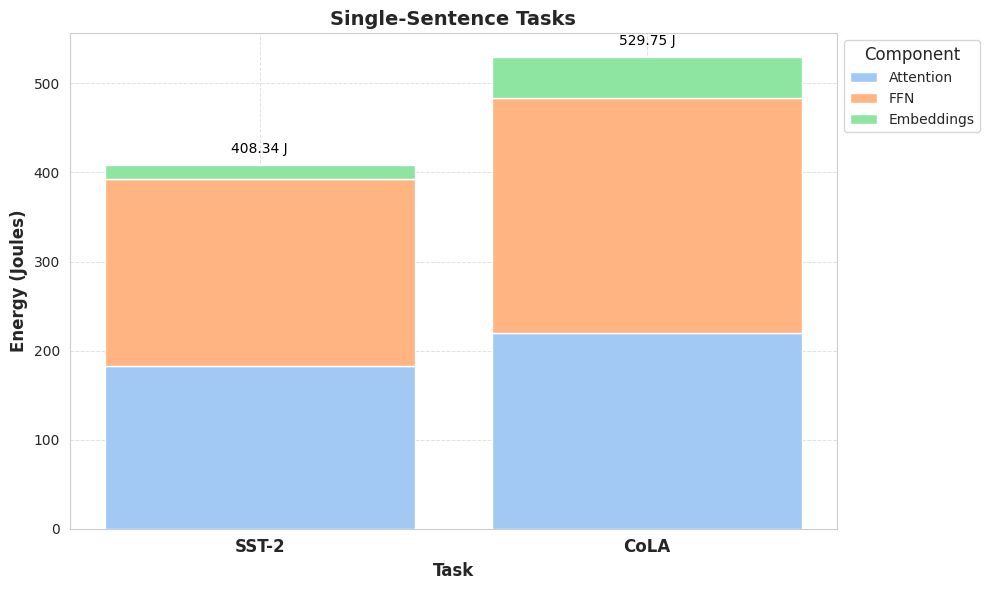

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the Seaborn style for attractiveness
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Data for each task (energies are in Joules)
tasks_single_sentence = ['SST-2', 'CoLA']
attention_energies_single = [182.73, 219.80]  # Attention energies (J)
ffn_energies_single = [209.58, 264.38]       # FFN energies (J)
embeddings_energies_single = [16.03, 45.57]  # Embeddings energies (J)

# X-axis positions
x_single = np.arange(len(tasks_single_sentence))

# Plot the stacked bar chart for single-sentence tasks
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each energy component
bar1 = ax.bar(x_single, attention_energies_single, label='Attention', color=sns.color_palette("pastel")[0])
bar2 = ax.bar(x_single, ffn_energies_single, bottom=attention_energies_single, label='FFN', color=sns.color_palette("pastel")[1])
bar3 = ax.bar(x_single, embeddings_energies_single,
              bottom=np.array(attention_energies_single) + np.array(ffn_energies_single),
              label='Embeddings', color=sns.color_palette("pastel")[2])

# Add total energy annotations
for i, (att, ffn, emb) in enumerate(zip(attention_energies_single, ffn_energies_single, embeddings_energies_single)):
    total_energy = att + ffn + emb
    ax.text(i, total_energy + 10, f'{total_energy:.2f} J', ha='center', va='bottom', fontsize=10, fontweight='normal', color='black')

# Customization
ax.set_xlabel('Task', fontsize=12, fontweight='bold')
ax.set_ylabel('Energy (Joules)', fontsize=12, fontweight='bold')
ax.set_title('Single-Sentence Tasks', fontsize=14, fontweight='bold')
ax.set_xticks(x_single)
ax.set_xticklabels(tasks_single_sentence, fontsize=12, fontweight='bold')

# Set legend outside of the plot
ax.legend(title='Component', loc='upper left', bbox_to_anchor=(1, 1), fontsize=10, title_fontsize=12)

# Add gridlines for clarity
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()


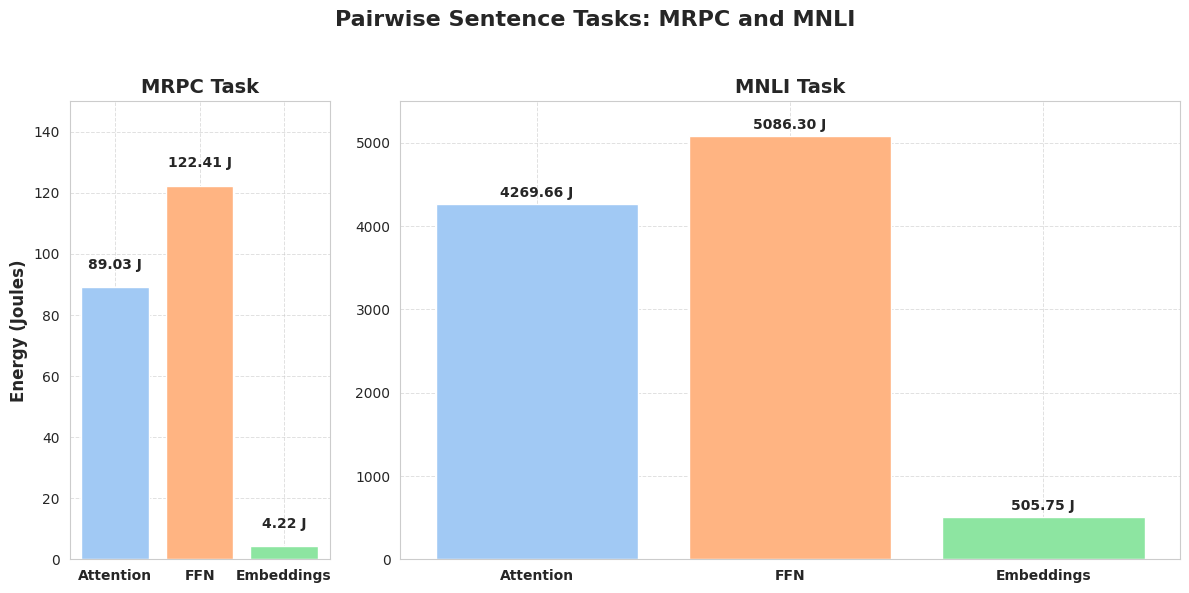

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the Seaborn style for attractiveness
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Data for MRPC and MNLI tasks (energies are in Joules)
tasks = ['MRPC', 'MNLI']

# Energy breakdown for MRPC task
attention_energies_mprc = 89.03  # Attention energies (J)
ffn_energies_mprc = 122.41       # FFN energies (J)
embeddings_energies_mprc = 4.22  # Embeddings energies (J)

# Energy breakdown for MNLI task
attention_energies_mnli = 4269.66  # Attention energies (J)
ffn_energies_mnli = 5086.30       # FFN energies (J)
embeddings_energies_mnli = 505.75  # Embeddings energies (J)

# Data grouped for plotting
energies_mprc = [attention_energies_mprc, ffn_energies_mprc, embeddings_energies_mprc]
energies_mnli = [attention_energies_mnli, ffn_energies_mnli, embeddings_energies_mnli]
components = ['Attention', 'FFN', 'Embeddings']

# X-axis positions
x_mprc = np.arange(len(components))  # MRPC positions
x_mnli = np.arange(len(components)) + len(components) + 1  # MNLI positions (spaced apart)

# Plot side-by-side bar charts with different scales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 3]})

# Plot MRPC task
ax1.bar(x_mprc, energies_mprc, color=sns.color_palette("pastel"), label=components)
ax1.set_title('MRPC Task', fontsize=14, fontweight='bold')
ax1.set_xticks(x_mprc)
ax1.set_xticklabels(components, fontsize=10, fontweight='bold')
ax1.set_ylabel('Energy (Joules)', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 150)  # Adjust scale for MRPC

# Add annotations for MRPC
for i, energy in enumerate(energies_mprc):
    ax1.text(i, energy + 5, f'{energy:.2f} J', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot MNLI task
ax2.bar(x_mnli, energies_mnli, color=sns.color_palette("pastel"), label=components)
ax2.set_title('MNLI Task', fontsize=14, fontweight='bold')
ax2.set_xticks(x_mnli)
ax2.set_xticklabels(components, fontsize=10, fontweight='bold')
ax2.set_ylim(0, 5500)  # Adjust scale for MNLI

# Add annotations for MNLI
for i, energy in enumerate(energies_mnli):
    ax2.text(x_mnli[i], energy + 50, f'{energy:.2f} J', ha='center', va='bottom', fontsize=10, fontweight='bold')

# General title
fig.suptitle('Pairwise Sentence Tasks: MRPC and MNLI', fontsize=16, fontweight='bold')

# Adjust layout and add gridlines
for ax in [ax1, ax2]:
    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for suptitle
plt.show()



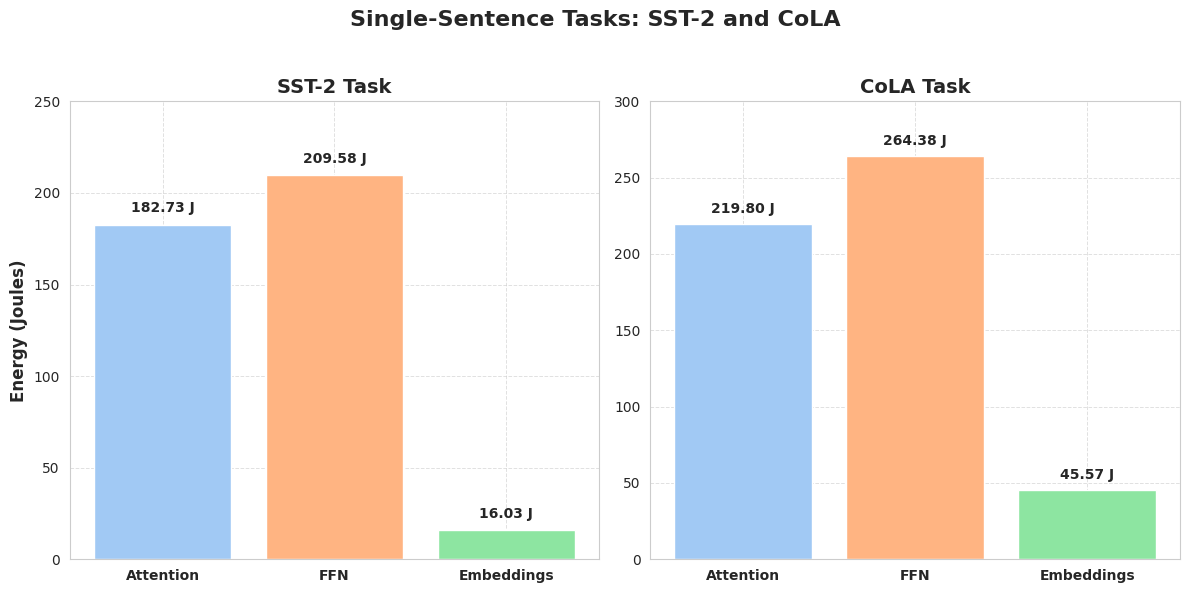

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the Seaborn style for attractiveness
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Data for Single-Sentence Tasks (energies are in Joules)
tasks = ['SST-2', 'CoLA']

# Energy breakdown for SST-2 task
attention_energies_sst2 = 182.73  # Attention energies (J)
ffn_energies_sst2 = 209.58       # FFN energies (J)
embeddings_energies_sst2 = 16.03  # Embeddings energies (J)

# Energy breakdown for CoLA task
attention_energies_cola = 219.80  # Attention energies (J)
ffn_energies_cola = 264.38        # FFN energies (J)
embeddings_energies_cola = 45.57  # Embeddings energies (J)

# Data grouped for plotting
energies_sst2 = [attention_energies_sst2, ffn_energies_sst2, embeddings_energies_sst2]
energies_cola = [attention_energies_cola, ffn_energies_cola, embeddings_energies_cola]
components = ['Attention', 'FFN', 'Embeddings']

# X-axis positions
x_sst2 = np.arange(len(components))  # SST-2 positions
x_cola = np.arange(len(components)) + len(components) + 1  # CoLA positions (spaced apart)

# Plot side-by-side bar charts with different scales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1]})

# Plot SST-2 task
ax1.bar(x_sst2, energies_sst2, color=sns.color_palette("pastel"), label=components)
ax1.set_title('SST-2 Task', fontsize=14, fontweight='bold')
ax1.set_xticks(x_sst2)
ax1.set_xticklabels(components, fontsize=10, fontweight='bold')
ax1.set_ylabel('Energy (Joules)', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 250)  # Adjust scale for SST-2

# Add annotations for SST-2
for i, energy in enumerate(energies_sst2):
    ax1.text(i, energy + 5, f'{energy:.2f} J', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot CoLA task
ax2.bar(x_cola, energies_cola, color=sns.color_palette("pastel"), label=components)
ax2.set_title('CoLA Task', fontsize=14, fontweight='bold')
ax2.set_xticks(x_cola)
ax2.set_xticklabels(components, fontsize=10, fontweight='bold')
ax2.set_ylim(0, 300)  # Adjust scale for CoLA

# Add annotations for CoLA
for i, energy in enumerate(energies_cola):
    ax2.text(x_cola[i], energy + 5, f'{energy:.2f} J', ha='center', va='bottom', fontsize=10, fontweight='bold')

# General title
fig.suptitle('Single-Sentence Tasks: SST-2 and CoLA', fontsize=16, fontweight='bold')

# Adjust layout and add gridlines
for ax in [ax1, ax2]:
    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for suptitle
plt.show()


<ipython-input-90-3536d1a3ecc9>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(configurations, rotation=45, ha='right')
<ipython-input-90-3536d1a3ecc9>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(configurations, rotation=45, ha='right')


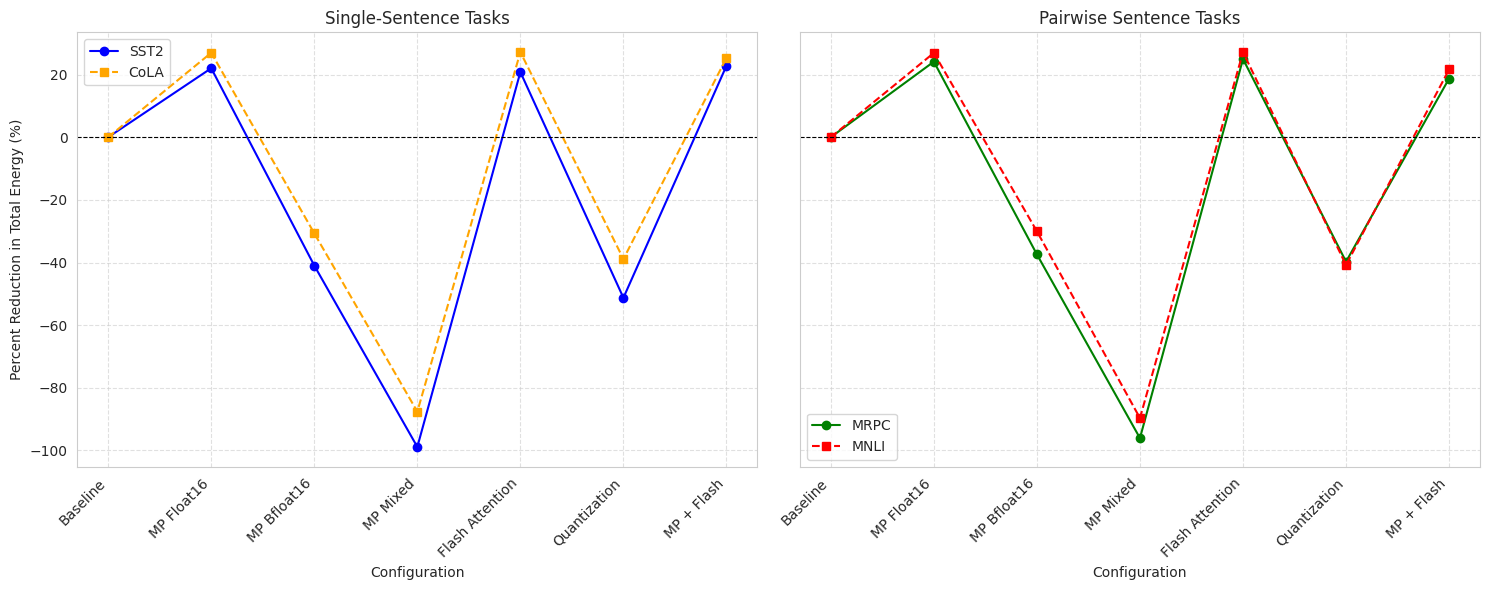

In [ ]:
import matplotlib.pyplot as plt

# Data for Single-Sentence Tasks (SST2, CoLA)
configurations = ['Baseline', 'MP Float16', 'MP Bfloat16', 'MP Mixed', 'Flash Attention', 'Quantization', 'MP + Flash']

sst2_reductions = [0, 22.02, -40.97, -98.87, 20.80, -51.26, 22.81]  # Percent reduction for SST2
cola_reductions = [0, 26.96, -30.69, -87.62, 27.18, -38.89, 25.32]  # Percent reduction for CoLA

# Data for Pairwise Tasks (MRPC, MNLI)
mrpc_reductions = [0, 24.12, -37.41, -96.06, 24.98, -39.73, 18.73]  # Percent reduction for MRPC
mnli_reductions = [0, 26.92, -30.04, -89.66, 27.15, -40.80, 21.63]  # Percent reduction for MNLI

# Create subplots for Single-Sentence Tasks vs Pairwise Tasks
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot Single-Sentence Tasks (SST2, CoLA)
axes[0].plot(configurations, sst2_reductions, marker='o', linestyle='-', label='SST2', color='blue')
axes[0].plot(configurations, cola_reductions, marker='s', linestyle='--', label='CoLA', color='orange')
axes[0].axhline(0, color='black', linestyle='--', linewidth=0.8)  # Zero line
axes[0].set_title('Single-Sentence Tasks')
axes[0].set_xlabel('Configuration')
axes[0].set_ylabel('Percent Reduction in Total Energy (%)')
axes[0].set_xticklabels(configurations, rotation=45, ha='right')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].legend()

# Plot Pairwise Tasks (MRPC, MNLI)
axes[1].plot(configurations, mrpc_reductions, marker='o', linestyle='-', label='MRPC', color='green')
axes[1].plot(configurations, mnli_reductions, marker='s', linestyle='--', label='MNLI', color='red')
axes[1].axhline(0, color='black', linestyle='--', linewidth=0.8)  # Zero line
axes[1].set_title('Pairwise Sentence Tasks')
axes[1].set_xlabel('Configuration')
axes[1].set_xticklabels(configurations, rotation=45, ha='right')
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].legend()

# Final adjustments and display
plt.tight_layout()
plt.show()


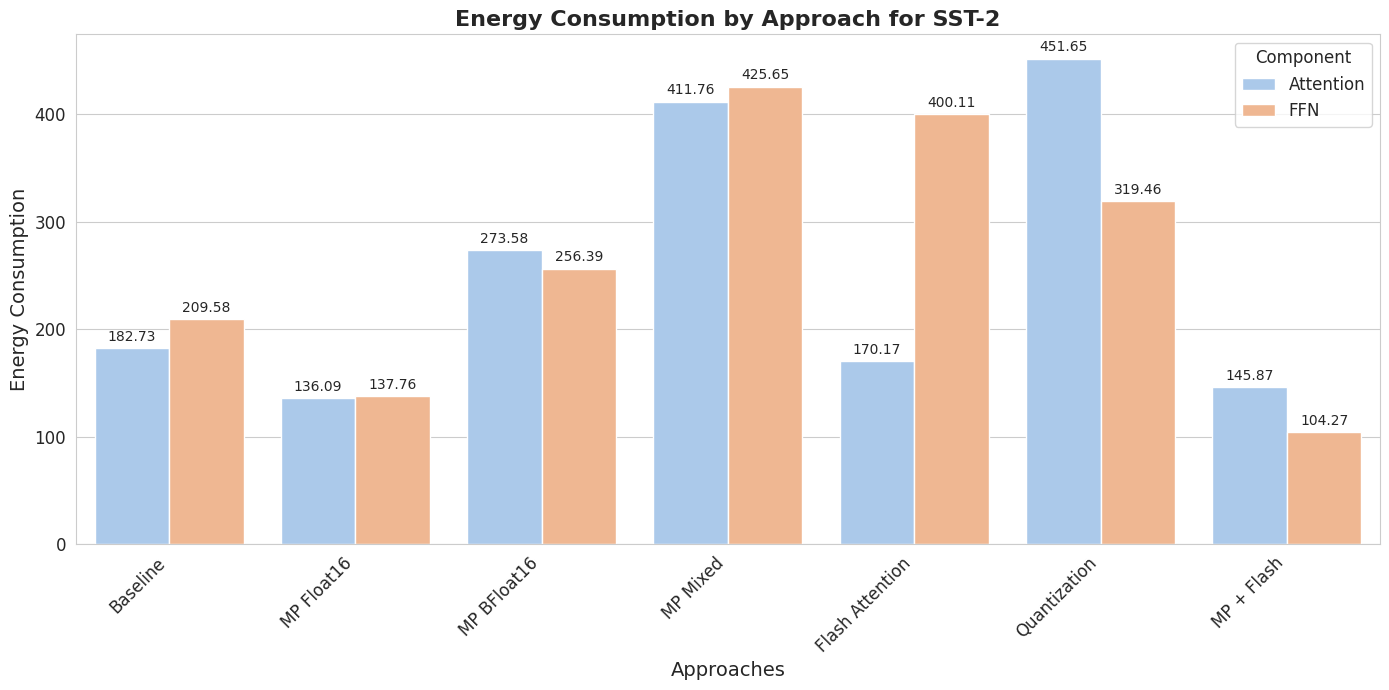

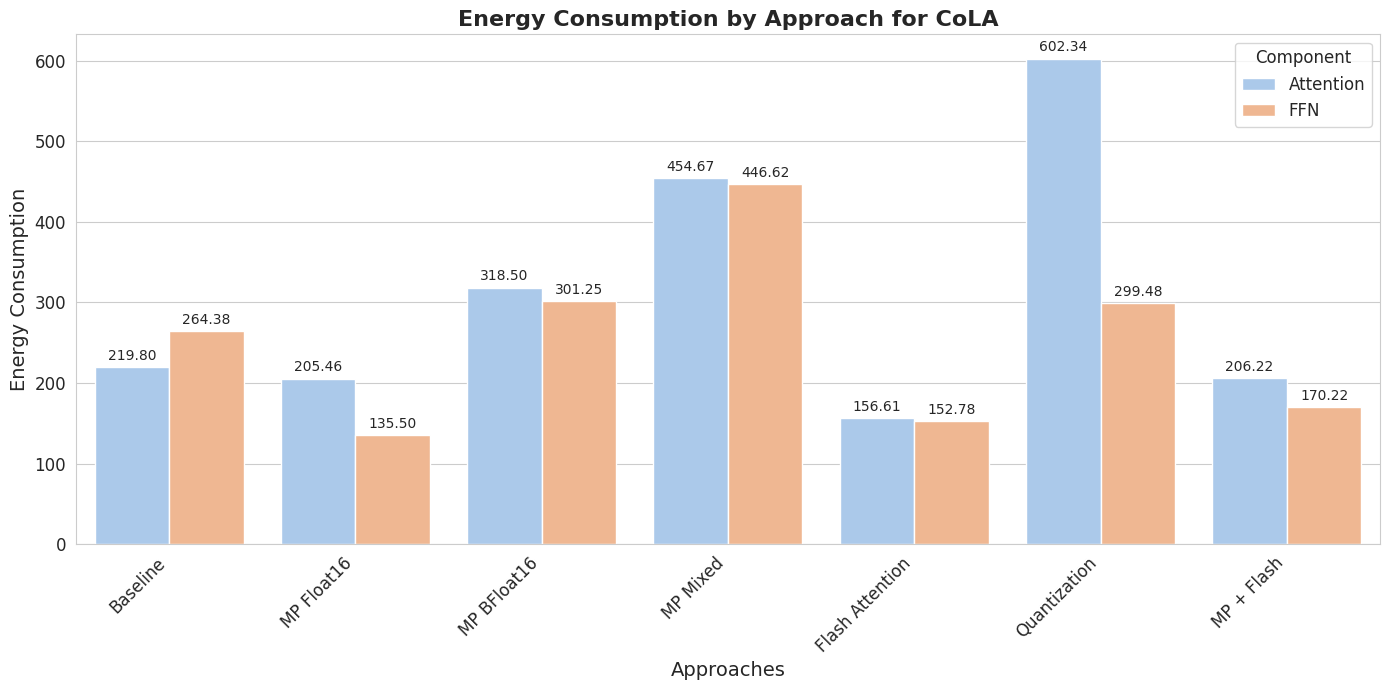

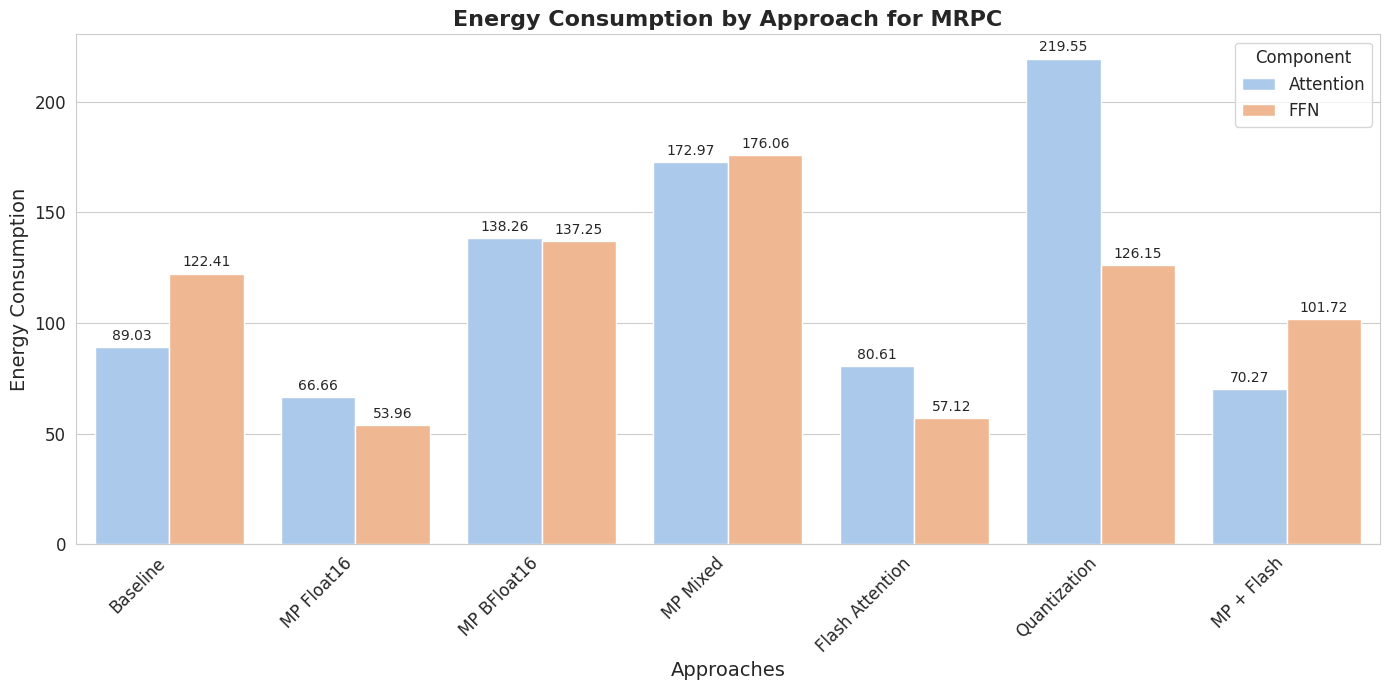

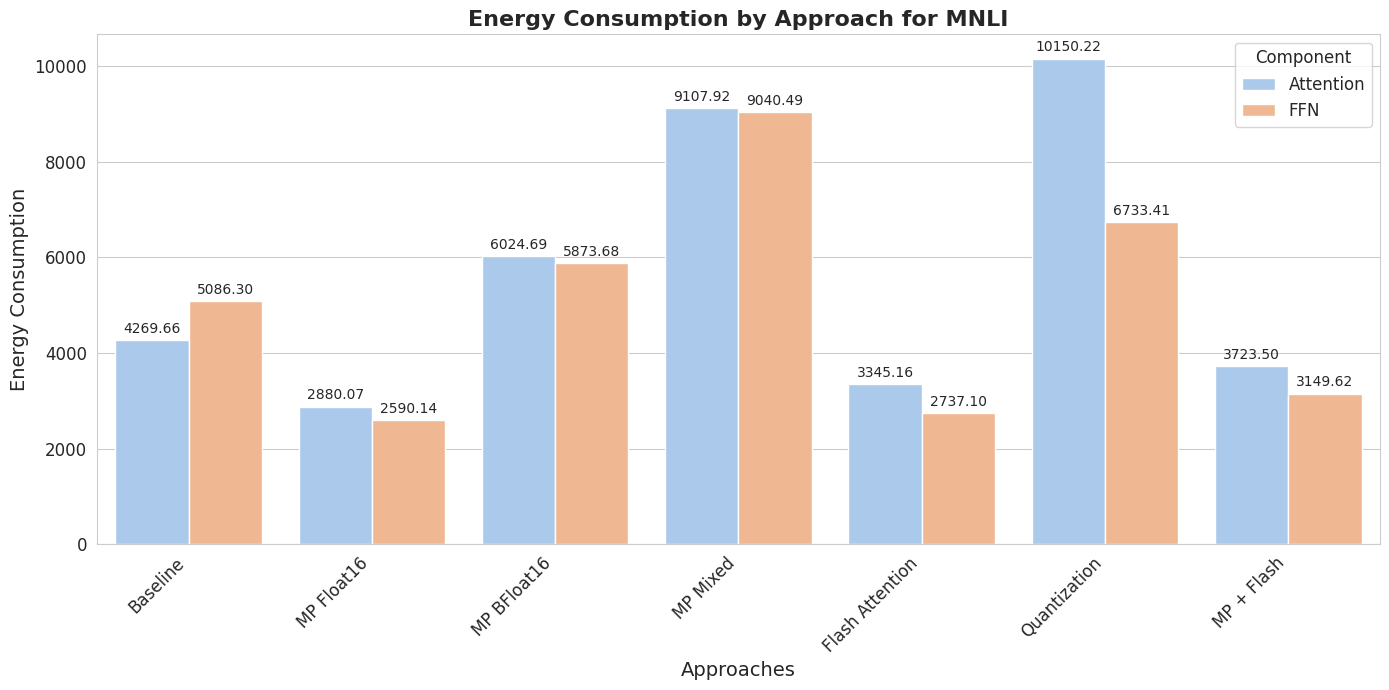

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Set Seaborn Style and Palette
sns.set_style("whitegrid")
sns.set_palette("pastel")

# 2. Data Preparation
data = {
    'SST-2': {
        'Approaches': ['Baseline', 'MP Float16', 'MP BFloat16', 'MP Mixed',
                      'Flash Attention', 'Quantization', 'MP + Flash'],
        'Attention': [182.73, 136.09, 273.58, 411.76, 170.17, 451.65, 145.87],
        'FFN': [209.58, 137.76, 256.39, 425.65, 400.11, 319.46, 104.27]
    },
    'CoLA': {
        'Approaches': ['Baseline', 'MP Float16', 'MP BFloat16', 'MP Mixed',
                      'Flash Attention', 'Quantization', 'MP + Flash'],
        'Attention': [219.80, 205.46, 318.50, 454.67, 156.61, 602.34, 206.22],
        'FFN': [264.38, 135.50, 301.25, 446.62, 152.78, 299.48, 170.22]
    },
    'MRPC': {
        'Approaches': ['Baseline', 'MP Float16', 'MP BFloat16', 'MP Mixed',
                      'Flash Attention', 'Quantization', 'MP + Flash'],
        'Attention': [89.03, 66.66, 138.26, 172.97, 80.61, 219.55, 70.27],
        'FFN': [122.41, 53.96, 137.25, 176.06, 57.12, 126.15, 101.72]
    },
    'MNLI': {
        'Approaches': ['Baseline', 'MP Float16', 'MP BFloat16', 'MP Mixed',
                      'Flash Attention', 'Quantization', 'MP + Flash'],
        'Attention': [4269.66, 2880.07, 6024.69, 9107.92, 3345.16, 10150.22, 3723.50],
        'FFN': [5086.30, 2590.14, 5873.68, 9040.49, 2737.10, 6733.41, 3149.62]
    }
}

tasks = ['SST-2', 'CoLA', 'MRPC', 'MNLI']

# 3. Visualization Function
def plot_energy_consumption(data, tasks):
    for task in tasks:
        # Create DataFrame for the current task
        df = pd.DataFrame({
            'Approaches': data[task]['Approaches'],
            'Attention': data[task]['Attention'],
            'FFN': data[task]['FFN']
        })

        # Melt the DataFrame to long format for Seaborn
        df_melted = df.melt(id_vars='Approaches', value_vars=['Attention', 'FFN'],
                            var_name='Component', value_name='Energy')

        # Initialize the matplotlib figure
        plt.figure(figsize=(14, 7))

        # Create a bar plot with Seaborn
        bar_plot = sns.barplot(data=df_melted, x='Approaches', y='Energy', hue='Component')

        # Add Title and Labels
        plt.title(f'Energy Consumption by Approach for {task}', fontsize=16, weight='bold')
        plt.xlabel('Approaches', fontsize=14)
        plt.ylabel('Energy Consumption', fontsize=14)

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45, ha='right', fontsize=12)
        plt.yticks(fontsize=12)

        # Add annotations on top of each bar
        for container in bar_plot.containers:
            bar_plot.bar_label(container, fmt='%.2f', fontsize=10, padding=3)

        # Customize Legend
        plt.legend(title='Component', fontsize=12, title_fontsize=12)

        # Adjust layout for better fit
        plt.tight_layout()

        # Display the plot
        plt.show()

# 4. Execute the Visualization
plot_energy_consumption(data, tasks)


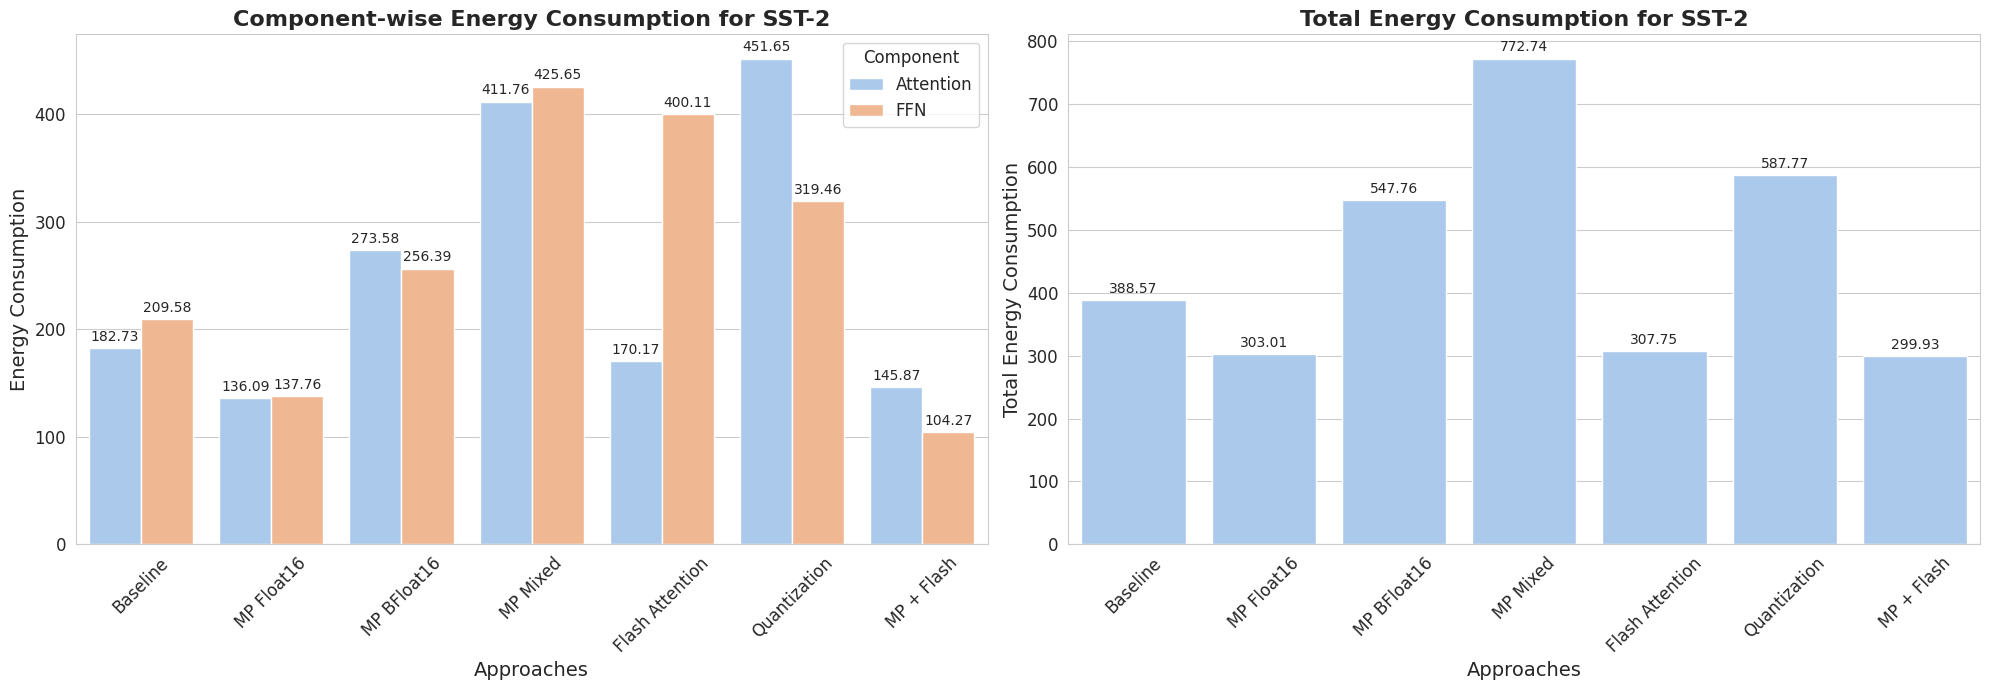

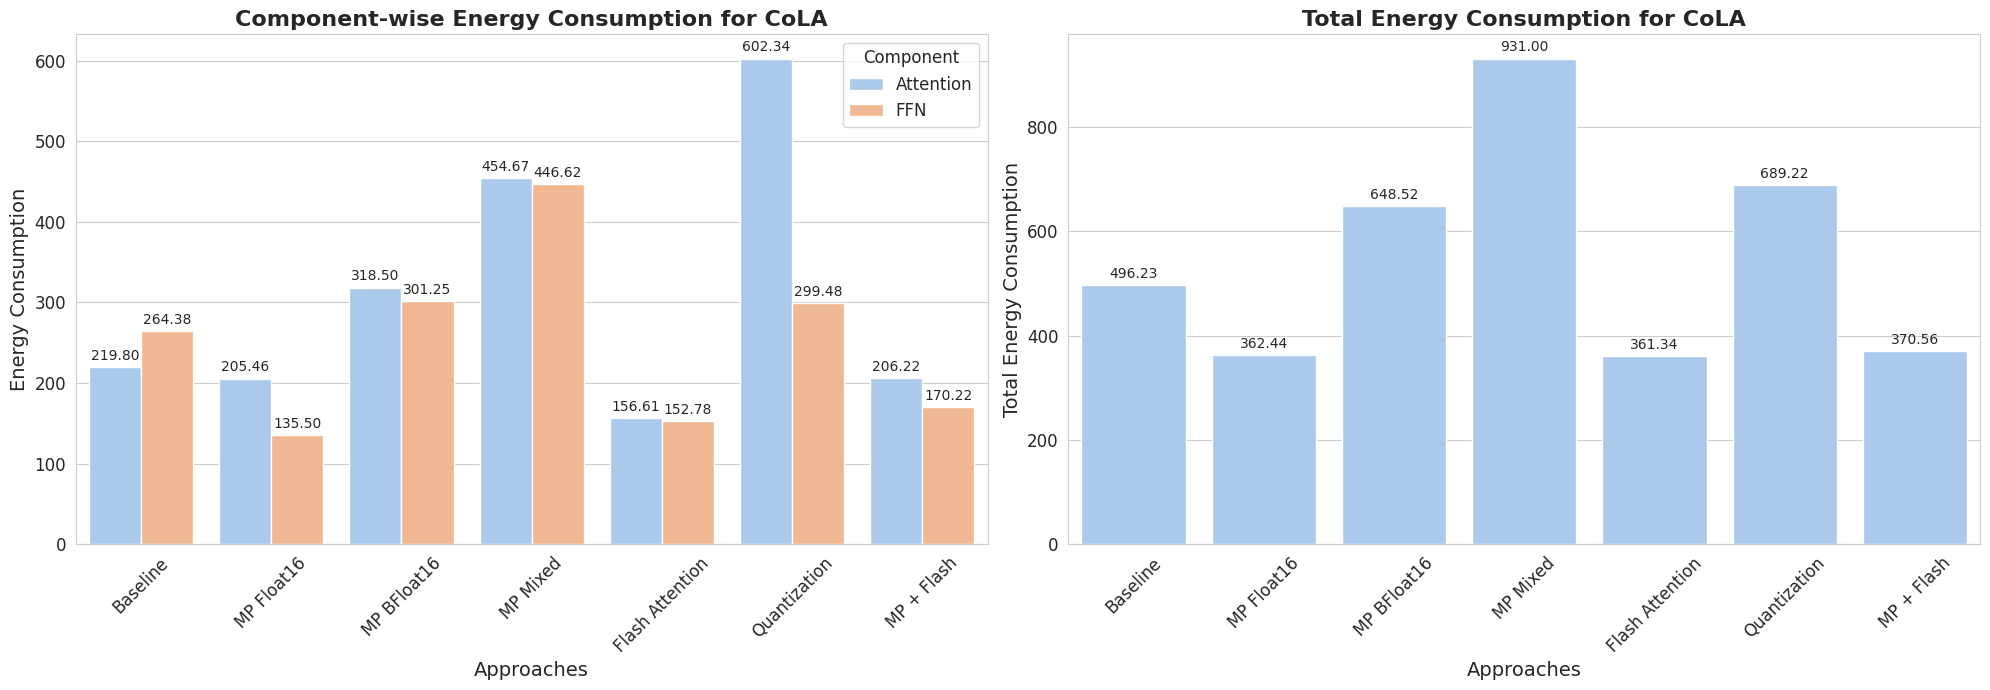

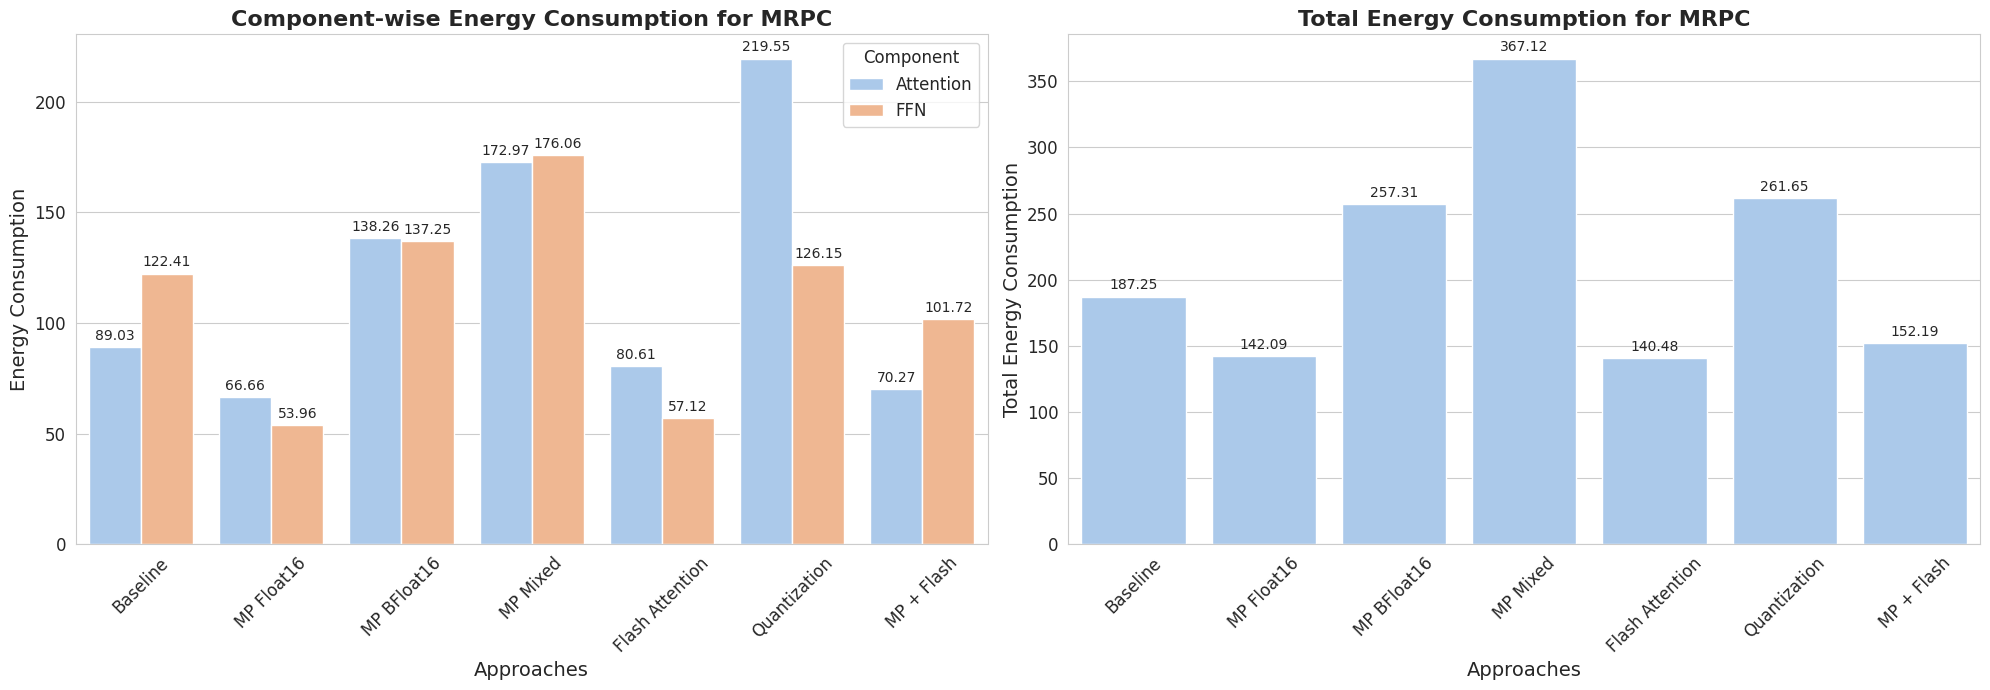

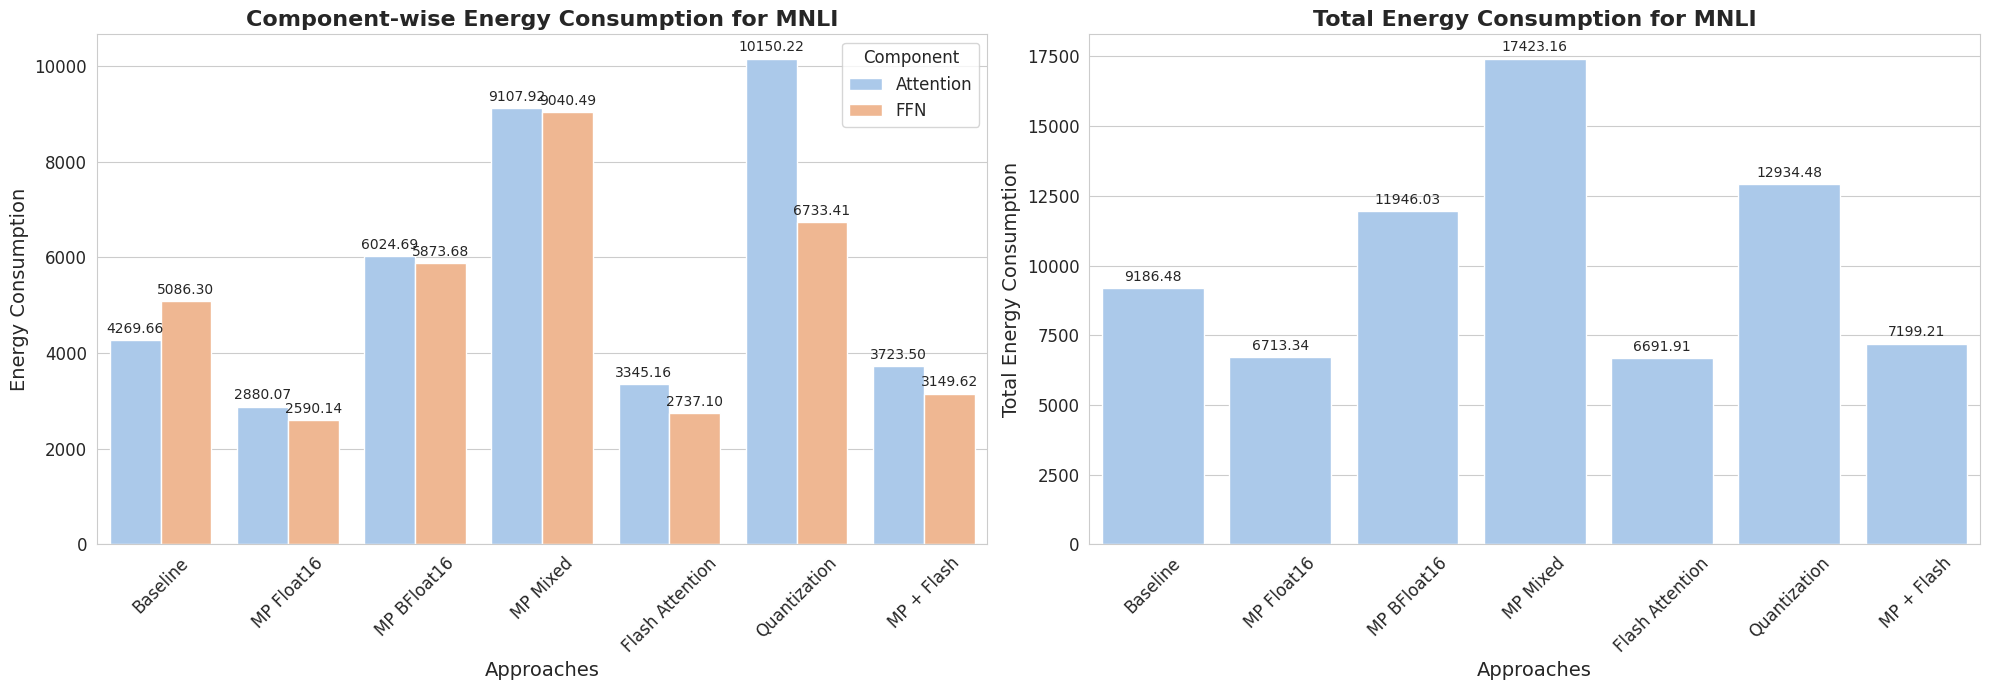

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Set Seaborn Style and Palette
sns.set_style("whitegrid")
sns.set_palette("pastel")

# 2. Data Preparation
data = {
    'SST-2': {
        'Approaches': ['Baseline', 'MP Float16', 'MP BFloat16', 'MP Mixed',
                      'Flash Attention', 'Quantization', 'MP + Flash'],
        'Total Energy': [388.573, 303.006, 547.761, 772.743, 307.751, 587.766, 299.929],
        'Attention': [182.73, 136.09, 273.58, 411.76, 170.17, 451.65, 145.87],
        'FFN': [209.58, 137.76, 256.39, 425.65, 400.11, 319.46, 104.27]
    },
    'CoLA': {
        'Approaches': ['Baseline', 'MP Float16', 'MP BFloat16', 'MP Mixed',
                      'Flash Attention', 'Quantization', 'MP + Flash'],
        'Total Energy': [496.225, 362.4381, 648.518, 931, 361.3374, 689.218, 370.561],
        'Attention': [219.80, 205.46, 318.50, 454.67, 156.61, 602.34, 206.22],
        'FFN': [264.38, 135.50, 301.25, 446.62, 152.78, 299.48, 170.22]
    },
    'MRPC': {
        'Approaches': ['Baseline', 'MP Float16', 'MP BFloat16', 'MP Mixed',
                      'Flash Attention', 'Quantization', 'MP + Flash'],
        'Total Energy': [187.251, 142.0903, 257.307, 367.119, 140.4787, 261.65, 152.188],
        'Attention': [89.03, 66.66, 138.26, 172.97, 80.61, 219.55, 70.27],
        'FFN': [122.41, 53.96, 137.25, 176.06, 57.12, 126.15, 101.72]
    },
    'MNLI': {
        'Approaches': ['Baseline', 'MP Float16', 'MP BFloat16', 'MP Mixed',
                      'Flash Attention', 'Quantization', 'MP + Flash'],
        'Total Energy': [9186.482, 6713.3426, 11946.028, 17423.159, 6691.9123, 12934.484, 7199.207],
        'Attention': [4269.66, 2880.07, 6024.69, 9107.92, 3345.16, 10150.22, 3723.50],
        'FFN': [5086.30, 2590.14, 5873.68, 9040.49, 2737.10, 6733.41, 3149.62]
    }
}

tasks = ['SST-2', 'CoLA', 'MRPC', 'MNLI']

# 3. Visualization Function
def plot_energy_consumption(data, tasks):
    for task in tasks:
        # Create DataFrame for the current task
        df = pd.DataFrame({
            'Approaches': data[task]['Approaches'],
            'Attention': data[task]['Attention'],
            'FFN': data[task]['FFN'],
            'Total Energy': data[task]['Total Energy']
        })

        # Melt the DataFrame to long format for component breakdown
        df_components = df.melt(id_vars='Approaches', value_vars=['Attention', 'FFN'],
                                var_name='Component', value_name='Energy')

        # Melt the DataFrame to long format for total energy
        df_total = df[['Approaches', 'Total Energy']]

        # Initialize the matplotlib figure with two subplots
        fig, axes = plt.subplots(1, 2, figsize=(20, 7))

        # ------------------------
        # Plot 1: Component Breakdown
        # ------------------------
        sns.barplot(data=df_components, x='Approaches', y='Energy', hue='Component', ax=axes[0])

        # Add title and labels for component breakdown
        axes[0].set_title(f'Component-wise Energy Consumption for {task}', fontsize=16, weight='bold')
        axes[0].set_xlabel('Approaches', fontsize=14)
        axes[0].set_ylabel('Energy Consumption', fontsize=14)

        # Rotate x-axis labels for better readability using tick_params
        axes[0].tick_params(axis='x', rotation=45, labelsize=12)
        axes[0].tick_params(axis='y', labelsize=12)

        # Add annotations on top of each bar
        for container in axes[0].containers:
            axes[0].bar_label(container, fmt='%.2f', fontsize=10, padding=3)

        # Customize Legend
        axes[0].legend(title='Component', fontsize=12, title_fontsize=12)

        # ------------------------
        # Plot 2: Total Energy Consumption
        # ------------------------
        sns.barplot(data=df_total, x='Approaches', y='Total Energy', ax=axes[1])

        # Add title and labels for total energy
        axes[1].set_title(f'Total Energy Consumption for {task}', fontsize=16, weight='bold')
        axes[1].set_xlabel('Approaches', fontsize=14)
        axes[1].set_ylabel('Total Energy Consumption', fontsize=14)

        # Rotate x-axis labels for better readability using tick_params
        axes[1].tick_params(axis='x', rotation=45, labelsize=12)
        axes[1].tick_params(axis='y', labelsize=12)

        # Add annotations on top of each bar
        for container in axes[1].containers:
            axes[1].bar_label(container, fmt='%.2f', fontsize=10, padding=3)

        # Remove legend from the total energy plot if it exists
        if axes[1].legend_ is not None:
            axes[1].legend_.remove()

        # Adjust layout for better fit
        plt.tight_layout()

        # Display the plots
        plt.show()

# 4. Execute the Visualization
plot_energy_consumption(data, tasks)


In [ ]:
def plot_bubble_throughput_energy(data, tasks):
    for task in tasks:
        df = pd.DataFrame({
            'Approaches': data[task]['Approaches'],
            'Total Energy': data[task]['Total Energy'],
            'Avg Throughput': data[task]['Avg Throughput'],
            'Percent Reduction': data[task].get('Percent reduction in Total Energy', [0]*len(data[task]['Approaches']))
        })

        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(df['Total Energy'], df['Avg Throughput'],
                              s=(df['Percent Reduction'].abs() * 10) + 100,  # Scale bubble size
                              c=df['Percent Reduction'], cmap='RdYlGn', alpha=0.6, edgecolors='w', linewidth=0.5)

        plt.title(f'Throughput vs. Total Energy Consumption for {task}', fontsize=16, weight='bold')
        plt.xlabel('Total Energy Consumption', fontsize=14)
        plt.ylabel('Average Throughput (tokens/sec)', fontsize=14)

        # Annotate each point with the approach name
        for i in range(df.shape[0]):
            plt.annotate(df['Approaches'][i],
                         (df['Total Energy'][i], df['Avg Throughput'][i]),
                         textcoords="offset points", xytext=(10,5), ha='left', fontsize=9)

        # Add color bar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Percent Reduction in Total Energy (%)', fontsize=12)

        plt.grid(True, which="both", ls="--", linewidth=0.5)
        plt.tight_layout()
        plt.show()
# Execute the bubble chart throughput vs energy plot function
plot_bubble_throughput_energy(data, tasks)


KeyError: 'Avg Throughput'

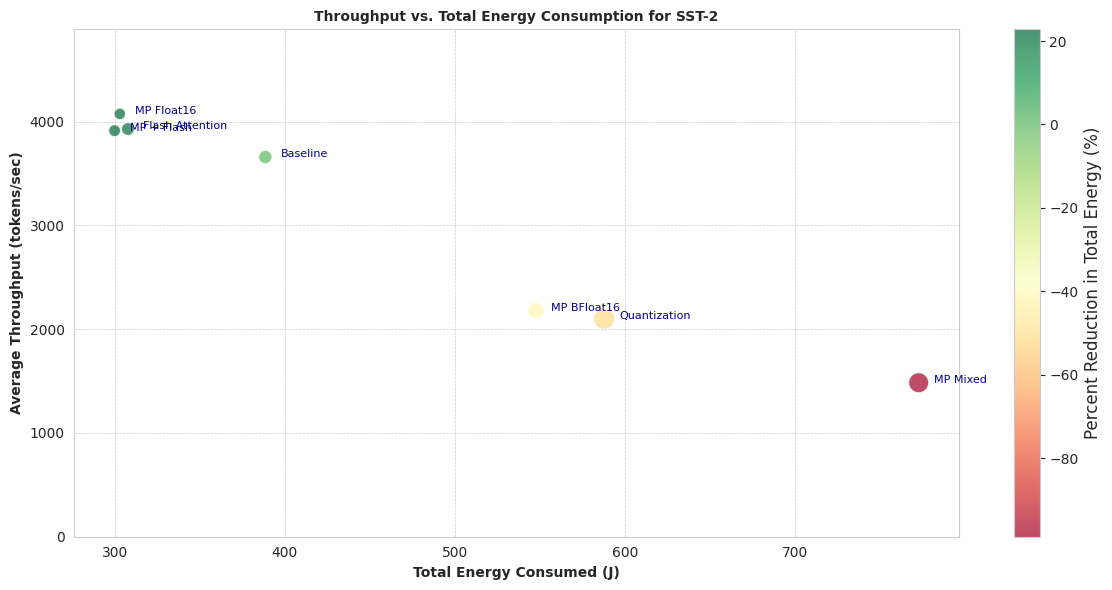

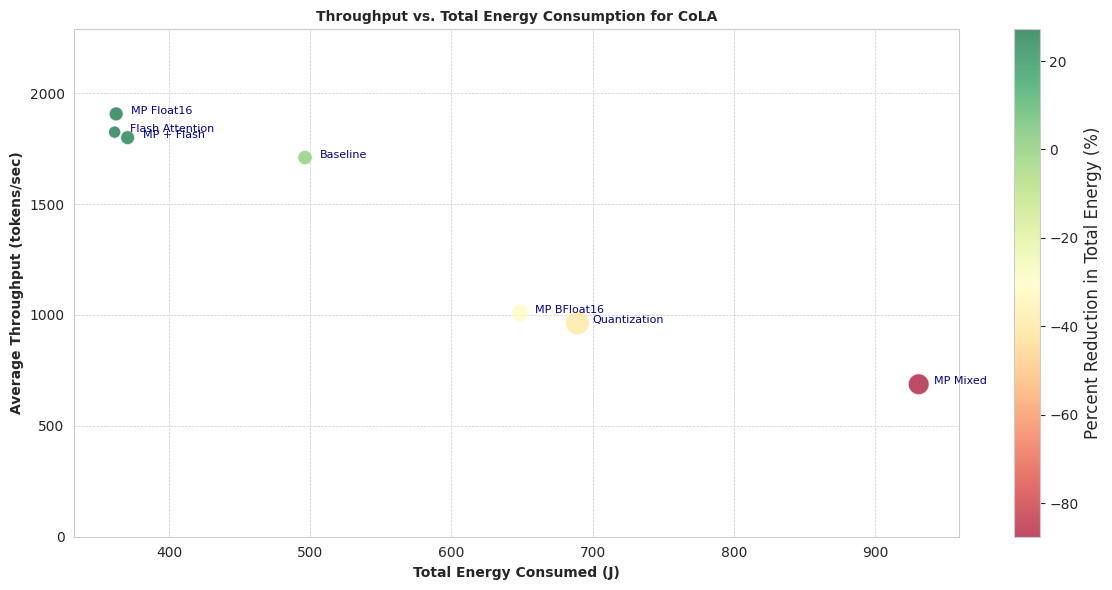

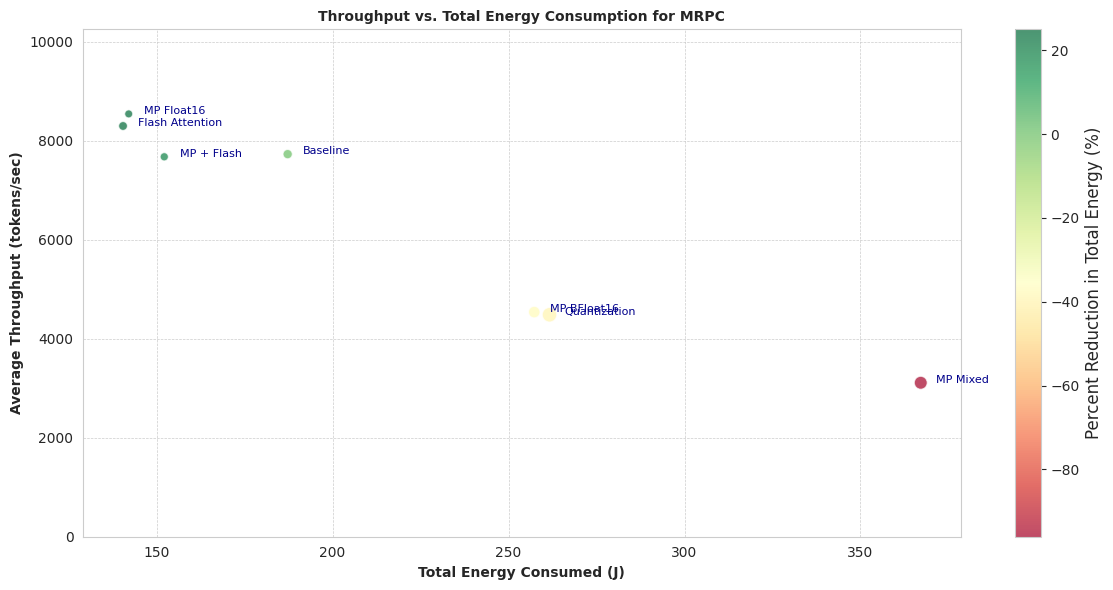

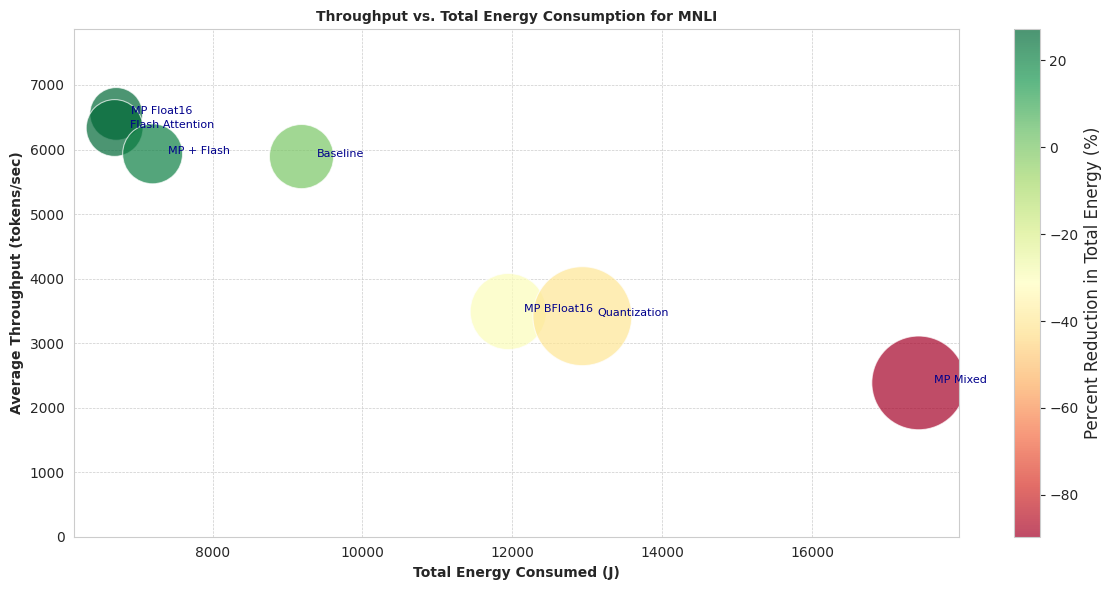

In [ ]:
data = {
    'SST-2': {
        'Approaches': ['Baseline', 'MP Float16', 'MP BFloat16', 'MP Mixed',
                      'Flash Attention', 'Quantization', 'MP + Flash'],
        'Attention': [182.73, 136.09, 273.58, 411.76, 170.17, 451.65, 145.87],
        'FFN': [209.58, 137.76, 256.39, 425.65, 400.11, 319.46, 104.27],
        'Embeddings': [16.03, 12.55, 49.82, 60.11, 60.11, 18.79, 23.40],
        'Total Energy': [388.573, 303.006, 547.761, 772.743, 307.751, 587.766, 299.929],
        'Average Throughput': [3658.4452, 4073.5871, 2177.6822, 1483.8804, 3927.9292, 2101.4607, 3912.1049],
        'Carbon Intensity': [182.7255147, 136.085823, 273.5753479, 411.7589676, 170.1727672, 451.6467393, 145.8728818],
        'Percent Reduction': [0, 22.02083006, -40.96733432, -98.86687958, 20.7996953, -51.2626971, 22.81270186]
    },
    'CoLA': {
        'Approaches': ['Baseline', 'MP Float16', 'MP BFloat16', 'MP Mixed',
                      'Flash Attention', 'Quantization', 'MP + Flash'],
        'Attention': [219.80, 205.46, 318.50, 454.67, 156.61, 602.34, 206.22],
        'FFN': [264.38, 135.50, 301.25, 446.62, 152.78, 299.48, 170.22],
        'Embeddings': [45.57, 13.93, 63.39, 80.34, 24.88, 25.99, 29.96],
        'Total Energy': [496.225, 362.4381, 648.518, 931, 361.3374, 689.218, 370.561],
        'Average Throughput': [1709.9613, 1906.9612, 1008.4878, 687.626, 1824.6967, 964.6759, 1799.8343],
        'Carbon Intensity': [219.8024566, 205.4639318, 318.5000872, 454.6701634, 156.6085743, 602.3416004, 206.2157022],
        'Percent Reduction': [0, 26.96093506, -30.69031185, -87.61650461, 27.18274976, -38.89223638, 25.32399617]
    },
    'MRPC': {
        'Approaches': ['Baseline', 'MP Float16', 'MP BFloat16', 'MP Mixed',
                      'Flash Attention', 'Quantization', 'MP + Flash'],
        'Attention': [89.03, 66.66, 138.26, 172.97, 80.61, 219.55, 70.27],
        'FFN': [122.41, 53.97, 137.25, 176.06, 57.12, 126.15, 101.72],
        'Embeddings': [4.22, 14.21, 14.46, 29.11, 14.08, 4.35, 8.89],
        'Total Energy': [187.251, 142.0903, 257.307, 367.119, 140.4787, 261.65, 152.188],
        'Average Throughput': [7732.9573, 8546.4043, 4540.4528, 3111.8531, 8302.0584, 4486.6947, 7679.6345],
        'Carbon Intensity': [89.03142294, 66.65832334, 138.2615321, 172.9729922, 80.60524851, 219.5513936, 70.26731314],
        'Percent Reduction': [0, 24.11773502, -37.41288431, -96.05716391, 24.97839798, -39.73223107, 18.72513364]
    },
    'MNLI': {
        'Approaches': ['Baseline', 'MP Float16', 'MP BFloat16', 'MP Mixed',
                      'Flash Attention', 'Quantization', 'MP + Flash'],
        'Attention': [4269.66, 2880.07, 6024.69, 9107.92, 3345.16, 10150.22, 3723.50],
        'FFN': [5086.30, 2590.14, 5873.68, 9040.49, 2737.10, 6733.41, 3149.62],
        'Embeddings': [505.75, 421.02, 1013.02, 1485.22, 423.54, 440.31, 433.17],
        'Total Energy': [9186.482, 6713.3426, 11946.028, 17423.159, 6691.9123, 12934.484, 7199.207],
        'Average Throughput': [5891.1426, 6552.1518, 3489.4689, 2383.8842, 6333.8994, 3417.9078, 5933.2541],
        'Carbon Intensity': [4269.656674, 2880.070932, 6024.692481, 9107.923021, 3345.157031, 10150.21727, 3723.502524],
        'Percent Reduction': [0, 26.92150706, -30.03920326, -89.66084079, 27.15478787, -40.79910024, 21.63260103]
    }
}

def plot_bubble_throughput_energy(data, tasks):
    for task in tasks:
        df = pd.DataFrame({
            'Approaches': data[task]['Approaches'],
            'Total Energy': data[task]['Total Energy'],
            'Average Throughput': data[task]['Average Throughput'],
            'Percent Reduction': data[task]['Percent Reduction'],
            'Carbon Intensity': data[task]['Carbon Intensity']
        })

        plt.figure(figsize=(12, 6))
        scatter = plt.scatter(df['Total Energy'], df['Average Throughput'],
                              s=df['Carbon Intensity'] * 0.5,  # Scale bubble size using Carbon Intensity
                              c=df['Percent Reduction'], cmap='RdYlGn', alpha=0.7, edgecolors='w', linewidth=0.8)

        plt.title(f'Throughput vs. Total Energy Consumption for {task}', fontsize=10, weight='bold')
        plt.xlabel('Total Energy Consumed (J)', fontsize=10, weight='bold')
        plt.ylabel('Average Throughput (tokens/sec)', fontsize=10, weight='bold')

        #
        for i in range(df.shape[0]):
            plt.annotate(df['Approaches'][i],
                         (df['Total Energy'][i], df['Average Throughput'][i]),
                         textcoords="offset points", xytext=(11,0), fontsize=8, color='darkblue')

        # Add color bar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Percent Reduction in Total Energy (%)', fontsize=12)

        plt.grid(True, which="both", ls="--", linewidth=0.5)
        plt.ylim(0, df['Average Throughput'].max() * 1.2)
        plt.tight_layout()
        plt.show()



# Execute the bubble chart throughput vs energy plot function
plot_bubble_throughput_energy(data, tasks)

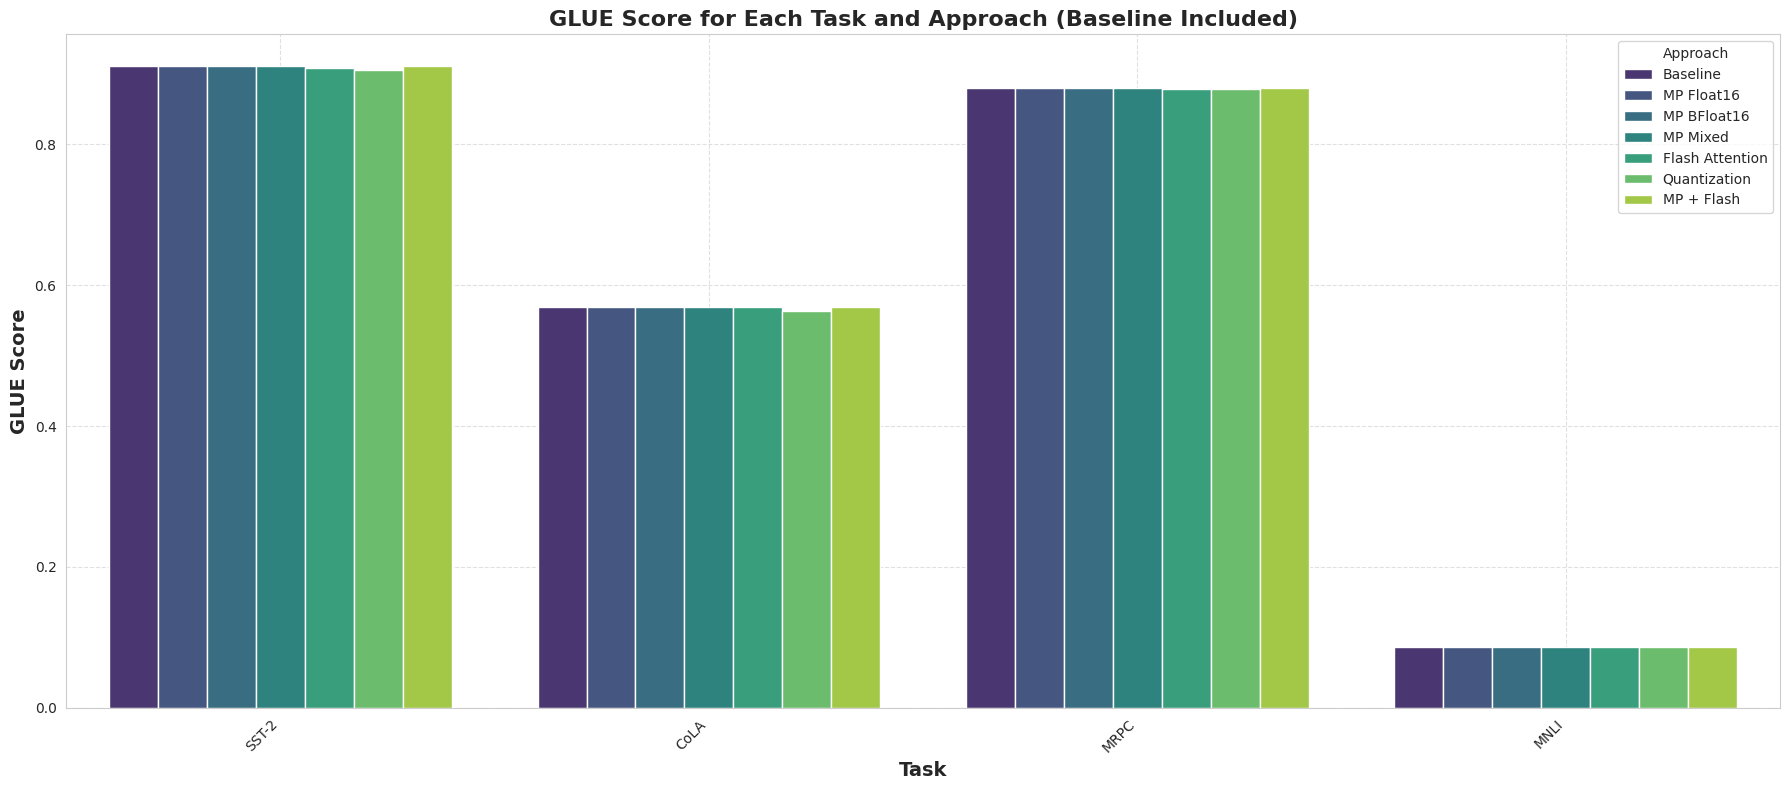

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set Seaborn style and palette
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Data for GLUE Scores for each task and approach
data = {
    'Task': ['SST-2', 'SST-2', 'SST-2', 'SST-2', 'SST-2', 'SST-2', 'SST-2',
             'CoLA', 'CoLA', 'CoLA', 'CoLA', 'CoLA', 'CoLA', 'CoLA',
             'MRPC', 'MRPC', 'MRPC', 'MRPC', 'MRPC', 'MRPC', 'MRPC',
             'MNLI', 'MNLI', 'MNLI', 'MNLI', 'MNLI', 'MNLI', 'MNLI'],
    'Approach': ['Baseline', 'MP Float16', 'MP BFloat16', 'MP Mixed', 'Flash Attention', 'Quantization', 'MP + Flash'] * 4,
    'GLUE Score': [0.9106, 0.9106, 0.9106, 0.9106, 0.9083, 0.906, 0.9106,
                   0.5686, 0.5686, 0.5686, 0.5686, 0.5689, 0.5634, 0.5686,
                   0.8803, 0.8803, 0.8803, 0.8803, 0.8781, 0.8779, 0.8803,
                   0.0861, 0.0861, 0.0861, 0.0861, 0.0859, 0.0855, 0.0861]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set plot size
plt.figure(figsize=(18, 8))

# Create grouped bar chart
sns.barplot(
    x='Task',
    y='GLUE Score',
    hue='Approach',
    data=df,
    palette='viridis'
)

# Customizing the plot
plt.title('GLUE Score for Each Task and Approach (Baseline Included)', fontsize=16, weight='bold')
plt.xlabel('Task', fontsize=14, weight='bold')
plt.ylabel('GLUE Score', fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.tight_layout()
plt.show()
